# End to End Data Science Life Cycle

![Data Science Life Cycle](https://www.edushots.com/upload/articles-images/8990b754abdbe6a2d6e3dcfad3473541623b8c4c.jpg)

# 1- Problem Understanding

**What is the Goal of the Competition ?**
* build a model to predict the market (responder_6) for up to six months in the future. using real-world data derived from production systems, which offers a glimpse into the daily challenges of successful trading.

**What Challenges Will We Face in Financial Market Modeling ?**
1. fat-tailed distributions
2. non-stationary time series
3. sudden shifts in market behavior

**What is the evaluation metric?**
* The competition uses the Sample Weighted Zero-Mean R-Squared Score as the evaluation metric.

**Why use Zero-Mean R-Squared?**

The idea behind zero-mean R² is to measure how well the model captures the variations (ups and downs) of the target variable, rather than its absolute level. In other words, we remove the weighted mean from both the true values and the predictions before computing R². This ensures that we evaluate the model based on its ability to follow the pattern and direction of changes, not on its absolute bias. If predictions follow the same pattern of change (ups and downs) as the true values → R² will be high, even if all predictions are shifted by a constant bias. If predictions do not capture the correct directions → R² will be low or negative.


#  2- Data Understanding 

**File Information**
1. train.parquet - The training set, contains historical data and returns. For convenience, the training set has been partitioned into ten parts.
2. test.parquet - A mock test set which represents the structure of the unseen test set.
3. lags.parquet - Values of responder_{0...8} lagged by one date_id.
4. sample_submission.csv - This file illustrates the format of the predictions your model should make.
5. features.csv - metadata pertaining to the anonymized features.
6. responders.csv - metadata pertaining to the anonymized responders

**Our columns in the train data consist of**
1. **responder_{0...8} - Anonymized responders.(responder_6) field is what are trying to predict.**
2. **feature_{00...78} - Anonymized market data.**
3. **date_id and time_id - Integer values that are ordinally sorted.**
4. **symbol_id - Identifies a unique financial instrument.**
6. **weight - The weighting used for calculating the scoring function.**

**let's explore each part**

In [1]:
# Data Manipulation and Analysis
import pandas as pd
import numpy as np
import os
from glob import glob
import re
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# Statistical Analysis and Time Series
from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
# Machine Learning and Explainability
import shap
import lightgbm as lgb
from sklearn.cluster import KMeans
# Metrices and preprocessing
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
# 
import warnings
import random
import gc
from tqdm import tqdm
import joblib
# Notebook settings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None 
pd.options.display.max_rows = None

In [2]:
# Data Path
DATA_PATH = "/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet"

# Automatically detect partitions instead of manually specifying them
partition_paths = sorted(glob(os.path.join(DATA_PATH, "partition_id=*/part-*.parquet")))

# Select a range of files
FIRST_PARTITIONS_TO_LOAD = 9
LAST_PARTITIONS_TO_LOAD = 10
selected_files = partition_paths[FIRST_PARTITIONS_TO_LOAD:LAST_PARTITIONS_TO_LOAD]

# Use a list comprehension to read the parquet files
dataframes = [pd.read_parquet(file) for file in selected_files]

train_df = pd.concat(dataframes, ignore_index=True)

print("Loaded shape:", train_df.shape)
train_df.head()

Loaded shape: (6274576, 92)


date_id  time_id  symbol_id    weight  feature_00  feature_01  feature_02  \
0     1530        0          0  3.084694    1.153571    1.563784    0.697396   
1     1530        0          1  2.232906    0.553354    1.730064    0.990195   
2     1530        0          2  2.404948    1.532503    2.095852    0.919688   
3     1530        0          3  1.986533    0.647099    1.687460    0.569406   
4     1530        0          4  2.742601    1.096778    1.551411    0.632113   

   feature_03  feature_04  feature_05  feature_06  feature_07  feature_08  \
0    0.756759    2.580965    0.171311    1.126353    0.536153    0.057150   
1    0.611490    2.023031    0.319015    1.183371    0.562853    0.057789   
2    0.583715    2.330047    0.337096    1.262236    0.496050    0.073556   
3    1.061679    2.444131    0.150487    0.896543    0.705652    0.072545   
4    0.368218    2.181873    0.214604    1.194230    0.261056    0.045426   

   feature_09  feature_10  feature_11  feature_12  feature_13  feature_14  \
0          11           7          76   -0.656288    2.110188    0.145784   
1          11           7          76   -1.063518    1.037634   -0.255358   
2          81           2          59   -1.001967    1.105770   -0.304426   
3           4           3          11   -0.966606    0.415421   -0.528979   
4          15           1           9   -0.895004    0.047908   -0.683484   

   feature_15  feature_16  feature_17  feature_18  feature_19  feature_20  \
0         NaN   -0.203291         NaN   -1.238222   -2.294707   -0.063560   
1         NaN   -0.318528         NaN   -1.466130   -2.160217    0.009386   
2         NaN   -0.531873         NaN   -1.301579   -1.615271    0.454406   
3         NaN    0.183964         NaN   -1.917427   -1.929856   -0.501750   
4         NaN   -0.638341         NaN   -1.558110   -1.203378   -0.305831   

   feature_21  feature_22  feature_23  feature_24  feature_25  feature_26  \
0   -0.148218    1.721362    0.645580    1.477857    0.528492    1.153077   
1    0.042186    0.319811    0.143070    1.866907    1.238242   -1.986826   
2   -0.188808    0.015120   -0.159487    1.379064    0.604568    0.736194   
3   -0.102371   -0.297677   -1.049185    0.933516   -0.606540   -0.039158   
4    0.251725    0.222749   -0.902276    4.226925    1.233024   -2.274672   

   feature_27  feature_28  feature_29  feature_30  feature_31  feature_32  \
0    0.466157    0.145568   -0.546845   -0.694435   -0.163897         NaN   
1   -0.476918    0.408439   -0.689795   -0.619278    0.081413         NaN   
2    0.522007   -0.183058   -0.632819   -0.839542   -0.209550         NaN   
3   -0.271960   -0.920819   -0.926502   -0.783003   -0.135720         NaN   
4   -1.065931   -0.229211   -0.597557   -0.990242    0.173607         NaN   

   feature_33  feature_34  feature_35  feature_36  feature_37  feature_38  \
0         NaN    0.502917    0.910145   -0.507707    0.218792    0.412922   
1         NaN    1.130648    0.726115    2.071485    0.179241    0.045131   
2         NaN    0.211059    0.788082   -0.575270    0.157013    0.178823   
3         NaN    1.007292    1.227438    1.663553   -0.243313   -0.049812   
4         NaN    1.103371    0.061046   -0.951203   -0.034542   -0.000886   

   feature_39  feature_40  feature_41  feature_42  feature_43  feature_44  \
0         NaN    0.081268         NaN         NaN   -2.023247         NaN   
1         NaN    0.002134         NaN         NaN   -0.828163         NaN   
2         NaN    0.486033         NaN         NaN   -1.121402         NaN   
3         NaN    1.388513         NaN         NaN    0.621888         NaN   
4         NaN    0.743995         NaN         NaN   -0.387709         NaN   

   feature_45  feature_46  feature_47  feature_48  feature_49  feature_50  \
0   -1.967165    0.262769   -0.426009   -3.682122   -1.549827         NaN   
1   -1.304763    0.870251   -0.095340   -0.888243   -0.159577         NaN   
2   -1.019831    0.741859   -1.735237   -0.707955 

In [3]:
# Data Info
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6274576 entries, 0 to 6274575
Data columns (total 92 columns):
 #   Column       Dtype  
---  ------       -----  
 0   date_id      int16  
 1   time_id      int16  
 2   symbol_id    int8   
 3   weight       float32
 4   feature_00   float32
 5   feature_01   float32
 6   feature_02   float32
 7   feature_03   float32
 8   feature_04   float32
 9   feature_05   float32
 10  feature_06   float32
 11  feature_07   float32
 12  feature_08   float32
 13  feature_09   int8   
 14  feature_10   int8   
 15  feature_11   int16  
 16  feature_12   float32
 17  feature_13   float32
 18  feature_14   float32
 19  feature_15   float32
 20  feature_16   float32
 21  feature_17   float32
 22  feature_18   float32
 23  feature_19   float32
 24  feature_20   float32
 25  feature_21   float32
 26  feature_22   float32
 27  feature_23   float32
 28  feature_24   float32
 29  feature_25   float32
 30  feature_26   float32
 31  feature_27   float32
 32

In [5]:
# Data Describe
train_df.describe()

date_id       time_id     symbol_id        weight    feature_00  \
count  1.241460e+07  1.241460e+07  1.241460e+07  1.241460e+07  1.241460e+07   
mean   1.530449e+03  4.835000e+02  1.899501e+01  2.513871e+00  1.468964e+00   
std    9.782383e+01  2.794374e+02  1.123725e+01  1.213540e+00  1.374677e+00   
min    1.360000e+03  0.000000e+00  0.000000e+00  3.947672e-01 -3.012856e+00   
25%    1.446000e+03  2.417500e+02  9.000000e+00  1.598893e+00  3.656579e-01   
50%    1.531000e+03  4.835000e+02  1.900000e+01  2.263819e+00  1.278629e+00   
75%    1.615000e+03  7.252500e+02  2.900000e+01  3.169882e+00  2.716877e+00   
max    1.698000e+03  9.670000e+02  3.800000e+01  9.096992e+00  6.477002e+00   

         feature_01    feature_02    feature_03    feature_04    feature_05  \
count  1.241460e+07  1.241460e+07  1.241460e+07  1.241460e+07  1.241460e+07   
mean   5.752740e-02  1.461302e+00  1.461192e+00  5.054472e-03 -6.701022e-02   
std    1.142326e+00  1.367243e+00  1.367482e+00  1.045019e+00  1.007730e+00   
min   -4.419564e+00 -3.748805e+00 -2.818514e+00 -4.363942e+00 -1.946321e+01   
25%   -7.154914e-01  3.649580e-01  3.640825e-01 -7.156556e-01 -5.258540e-01   
50%    3.534170e-02  1.269240e+00  1.270057e+00  8.277991e-03 -6.897012e-02   
75%    7.893068e-01  2.720419e+00  2.717643e+00  7.157611e-01  3.996353e-01   
max    6.292391e+00  6.490265e+00  6.695623e+00  6.117287e+00  2.580398e+01   

         feature_06    feature_07    feature_08    feature_09    feature_10  \
count  1.241460e+07  1.241460e+07  1.221035e+07  1.241460e+07  1.241460e+07   
mean  -7.764308e-03 -2.301215e-02  1.494069e-01  3.247758e+01  4.959298e+00   
std    1.114263e+00  1.096681e+00  8.547953e-01  2.335766e+01  3.197328e+00   
min   -4.580797e+01 -3.466853e+01 -8.493840e+00  2.000000e+00  1.000000e+00   
25%   -4.910800e-01 -5.189560e-01 -3.297522e-01  1.100000e+01  3.000000e+00   
50%   -7.269288e-03 -4.009544e-02  7.808387e-02  3.000000e+01  4.000000e+00   
75%    4.753106e-01  4.528337e-01  5.637176e-01  4.900000e+01  7.000000e+00   
max    3.391214e+01  3.495397e+01  1.242303e+01  8.200000e+01  1.200000e+01   

         feature_11    feature_12    feature_13    feature_14    feature_15  \
count  1.241460e+07  1.241460e+07  1.241460e+07  1.241460e+07  1.210680e+07   
mean   1.670126e+02 -7.709125e-02 -5.138294e-02 -7.906727e-02 -7.057817e-01   
std    1.620803e+02  8.428531e-01  6.857747e-01  8.005542e-01  3.529757e-01   
min    9.000000e+00 -1.693389e+00 -8.778178e-01 -1.339518e+00 -1.688744e+00   
25%    4.000000e+01 -4.823806e-01 -3.475684e-01 -4.571996e-01 -8.493317e-01   
50%    7.600000e+01 -2.461163e-01 -2.219775e-01 -2.637932e-01 -7.200638e-01   
75%    2.300000e+02  1.072362e-01  9.323135e-03  5.665272e-02 -5.901936e-01   
max    5.390000e+02  1.394184e+02  2.516919e+02  1.691188e+02  4.909919e+01   

         feature_16    feature_17    feature_18    feature_19    feature_20  \
count  1.241460e+07  1.236330e+07  1.241460e+07  1.241460e+07  1.241460e+07   
mean  -5.854368e-01 -6.874791e-01 -6.327220e-02 -8.832441e-02 -2.781754e-01   
std    3.144765e-01  3.348146e-01  1.027382e+00  1.062383e+00  7.054734e-01   
min   -1.621175e+00 -1.731827e+00 -4.310348e+00 -4.400285e+00 -3.617125e+00   
25%   -7.146112e-01 -8.262877e-01 -7.653677e-01 -8.019546e-01 -6.729921e-01   
50%   -5.985966e-01 -6.990663e-01 -1.304914e-02 -7.964279e-02 -2.167342e-01   
75%   -4.797558e-01 -5.708287e-01  6.334272e-01  6.481260e-01  1.952863e-01   
max    6.421616e+01  6.354889e+01  5.660179e+00  5.632606e+00  2.211102e+00   

         feature_21    feature_22    feature_23    feature_24    feature_25  \
count  1.233522e+07  1.241460e+07  1.241460e+07  1.241460e+07  1.241460e+07   
mean   7.342211e-02  1.762476e-01  1.254293e-01  1.760520e+00  2.290118e-01   
std    3.527855e-01  9.335773e-01  7.930085e-01  1.408405e+00  9.902496e-01   
min   -4.501374e-01 -1.886051e+00 -1.980721e+00 -1.412781e+00 -2.041592e+00   
25%   -1.522238e-01 -5.568774e-01 -4.907904e-01  7.950402

In [6]:
# Check for duplicted data
train_df.duplicated(subset=['date_id','time_id','symbol_id']).sum()

0

In [7]:
# Check for number of unique values for each column
train_df.nunique()

date_id             339
time_id             968
symbol_id            39
weight            12822
feature_00     10697717
feature_01     11454567
feature_02     10680255
feature_03     10682072
feature_04     11427255
feature_05     11603120
feature_06     11627925
feature_07     11607911
feature_08     11400562
feature_09           22
feature_10            9
feature_11           28
feature_12     11014332
feature_13     10566072
feature_14     10788278
feature_15      7743133
feature_16      7983619
feature_17      7862592
feature_18     11433113
feature_19     11432420
feature_20        12824
feature_21        12740
feature_22        12824
feature_23        12823
feature_24        12823
feature_25        12825
feature_26        12743
feature_27        12742
feature_28        12823
feature_29        12819
feature_30        12819
feature_31        12743
feature_32     10737251
feature_33     11404241
feature_34     10824137
feature_35     10827734
feature_36     11459706
feature_37     1

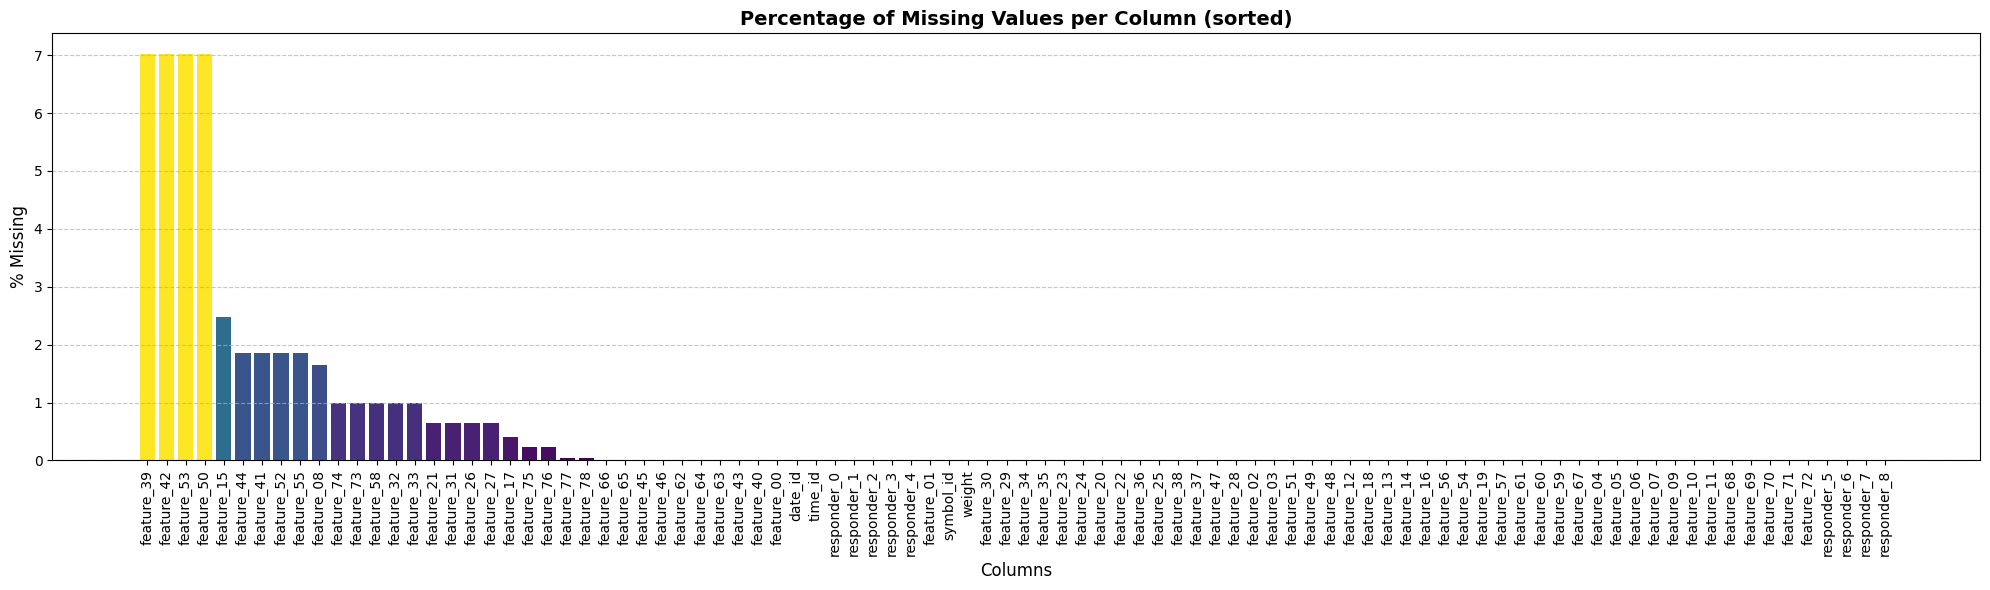

In [8]:
# Missing Ratio 
missing_ratio = train_df.isna().mean() * 100

# Sort Missing Values Columns
missing_ratio = missing_ratio.sort_values(ascending=False)

# Plt Missing Columns
plt.figure(figsize=(20, 6))
bars = plt.bar(
    x=missing_ratio.index,
    height=missing_ratio.values,
    color=plt.cm.viridis(missing_ratio.values / max(missing_ratio.values))  
)

# Rotattion Columns
plt.xticks(rotation=90, fontsize=10)

# Titile and labels
plt.title('Percentage of Missing Values per Column (sorted)', fontsize=14, fontweight='bold')
plt.ylabel('% Missing', fontsize=12)
plt.xlabel('Columns', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [9]:
# Drop columns with more than 60% missing values
threshold = 60
train_df = train_df.dropna(axis=1, thresh=len(train_df) * (1 - threshold/100))
print(f"\nReduced shape (after dropping >{threshold}% missing): {train_df.shape}")


Reduced shape (after dropping >60% missing): (12414600, 92)


##  2.1 - EDA Responders Columns

**Let's start with understand the structure of responders from csv file before anaylsis the columns in our train data**

In [8]:
resp_structure = pd.read_csv("/kaggle/input/jane-street-real-time-market-data-forecasting/responders.csv")
resp_structure

responder  tag_0  tag_1  tag_2  tag_3  tag_4
0  responder_0   True  False   True  False  False
1  responder_1   True  False  False   True  False
2  responder_2   True   True  False  False  False
3  responder_3  False  False   True  False   True
4  responder_4  False  False  False   True   True
5  responder_5  False   True  False  False   True
6  responder_6  False  False   True  False  False
7  responder_7  False  False  False   True  False
8  responder_8  False   True  False  False  False

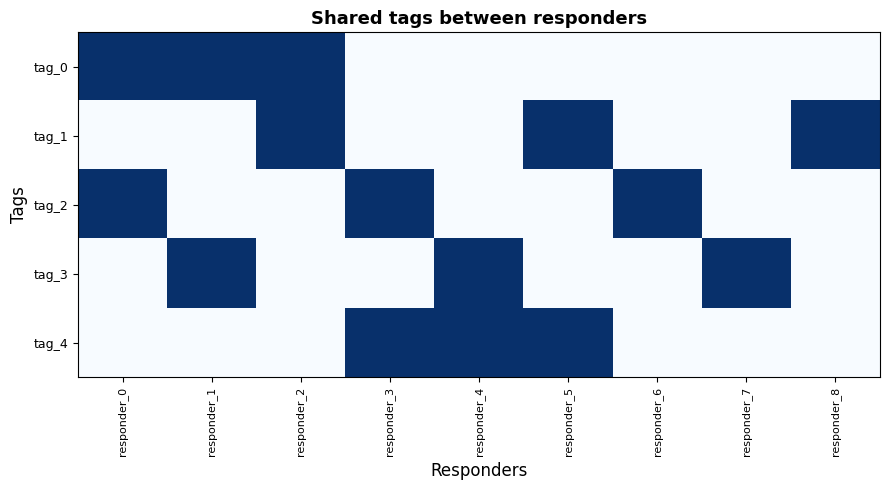

In [16]:
# PLot shared tags between responders
fig, ax = plt.subplots(figsize=(9,5))
ax.imshow(resp_structure.iloc[:, 1:].T, cmap="Blues", aspect="auto")

# x-axis: responders
ax.set_xticks(np.arange(resp_structure.shape[0]))
ax.set_xticklabels(resp_structure.loc[:,'responder'], rotation=90, fontsize=8)

# y-axis: tags
ax.set_yticks(np.arange(resp_structure.shape[1]-1))
ax.set_yticklabels(resp_structure.columns[1:], fontsize=9)

# labels
ax.set_xlabel("Responders", fontsize=12)
ax.set_ylabel("Tags", fontsize=12)

plt.title("Shared tags between responders", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()

In [10]:
#Groups of responders sharing the same tag
resp_structure.set_index("responder", inplace=True)

groups = []
for tag in resp_structure.columns:
    resp_group = resp_structure.index[resp_structure[tag]].tolist()
    groups.append((tag, resp_group))

print("=== Groups of responders sharing the same tag ===")
for tag, resp_group in groups:
    print(f"{tag}: {resp_group}")

=== Groups of responders sharing the same tag ===
tag_0: ['responder_0', 'responder_1', 'responder_2']
tag_1: ['responder_2', 'responder_5', 'responder_8']
tag_2: ['responder_0', 'responder_3', 'responder_6']
tag_3: ['responder_1', 'responder_4', 'responder_7']
tag_4: ['responder_3', 'responder_4', 'responder_5']


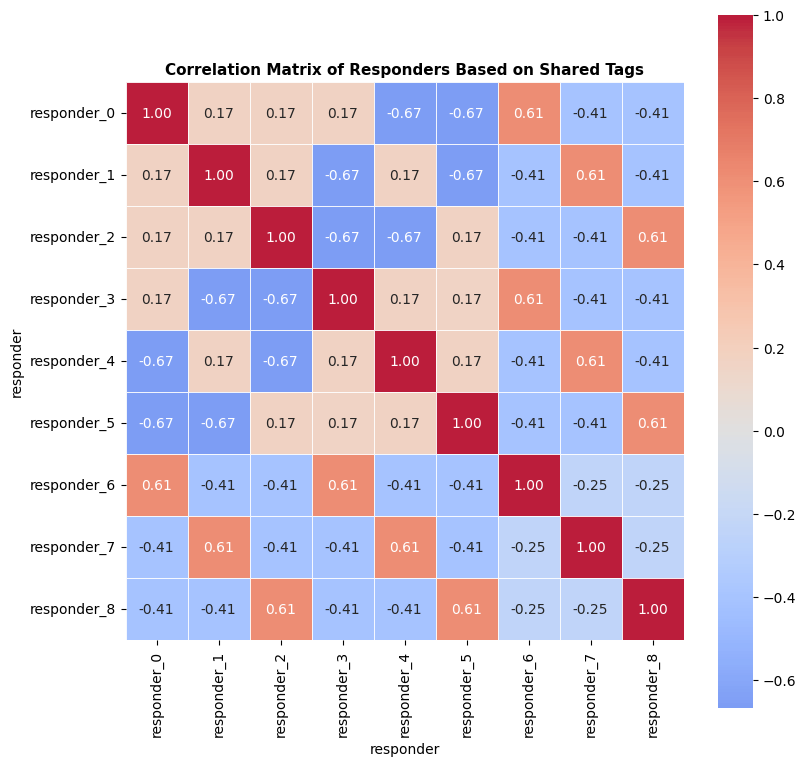

In [11]:
# Correlation Matrix
corr_matrix = resp_structure.T.corr()

# Heatmap
plt.figure(figsize=(9,9))
sns.heatmap(corr_matrix, square=True, cmap="coolwarm", alpha =0.9, center= 0, linewidths=0.5, annot=True, fmt=".2f")
plt.title("Correlation Matrix of Responders Based on Shared Tags", fontsize=11, fontweight="bold")
plt.show()

**responder_6  have a good correlation with responder_0 and responder_3**

**After finished analysis of reponders_structure in responders.csv file let's go to analysis reponders in train_df**

In [47]:
resp_cols = train_df.filter(like="responder_").columns
train_df[resp_cols].describe().round(1)

responder_0  responder_1  responder_2  responder_3  responder_4  \
count   12414600.0   12414600.0   12414600.0   12414600.0   12414600.0   
mean          -0.0          0.0          0.0         -0.1         -0.0   
std            0.5          0.5          0.5          0.9          0.9   
min           -5.0         -5.0         -5.0         -5.0         -5.0   
25%           -0.2         -0.1         -0.2         -0.3         -0.4   
50%           -0.0         -0.0         -0.0         -0.0         -0.1   
75%            0.2          0.1          0.2          0.2          0.3   
max            5.0          5.0          5.0          5.0          5.0   

       responder_5  responder_6  responder_7  responder_8  
count   12414600.0   12414600.0   12414600.0   12414600.0  
mean          -0.1         -0.0          0.0         -0.0  
std            0.9          0.8          0.8          0.8  
min           -5.0         -5.0         -5.0         -5.0  
25%           -0.2         -0.4         -0.4         -0.3  
50%           -0.0         -0.0         -0.0         -0.0  
75%            0.2          0.3          0.3          0.3  
max            5.0          5.0          5.0          5.0

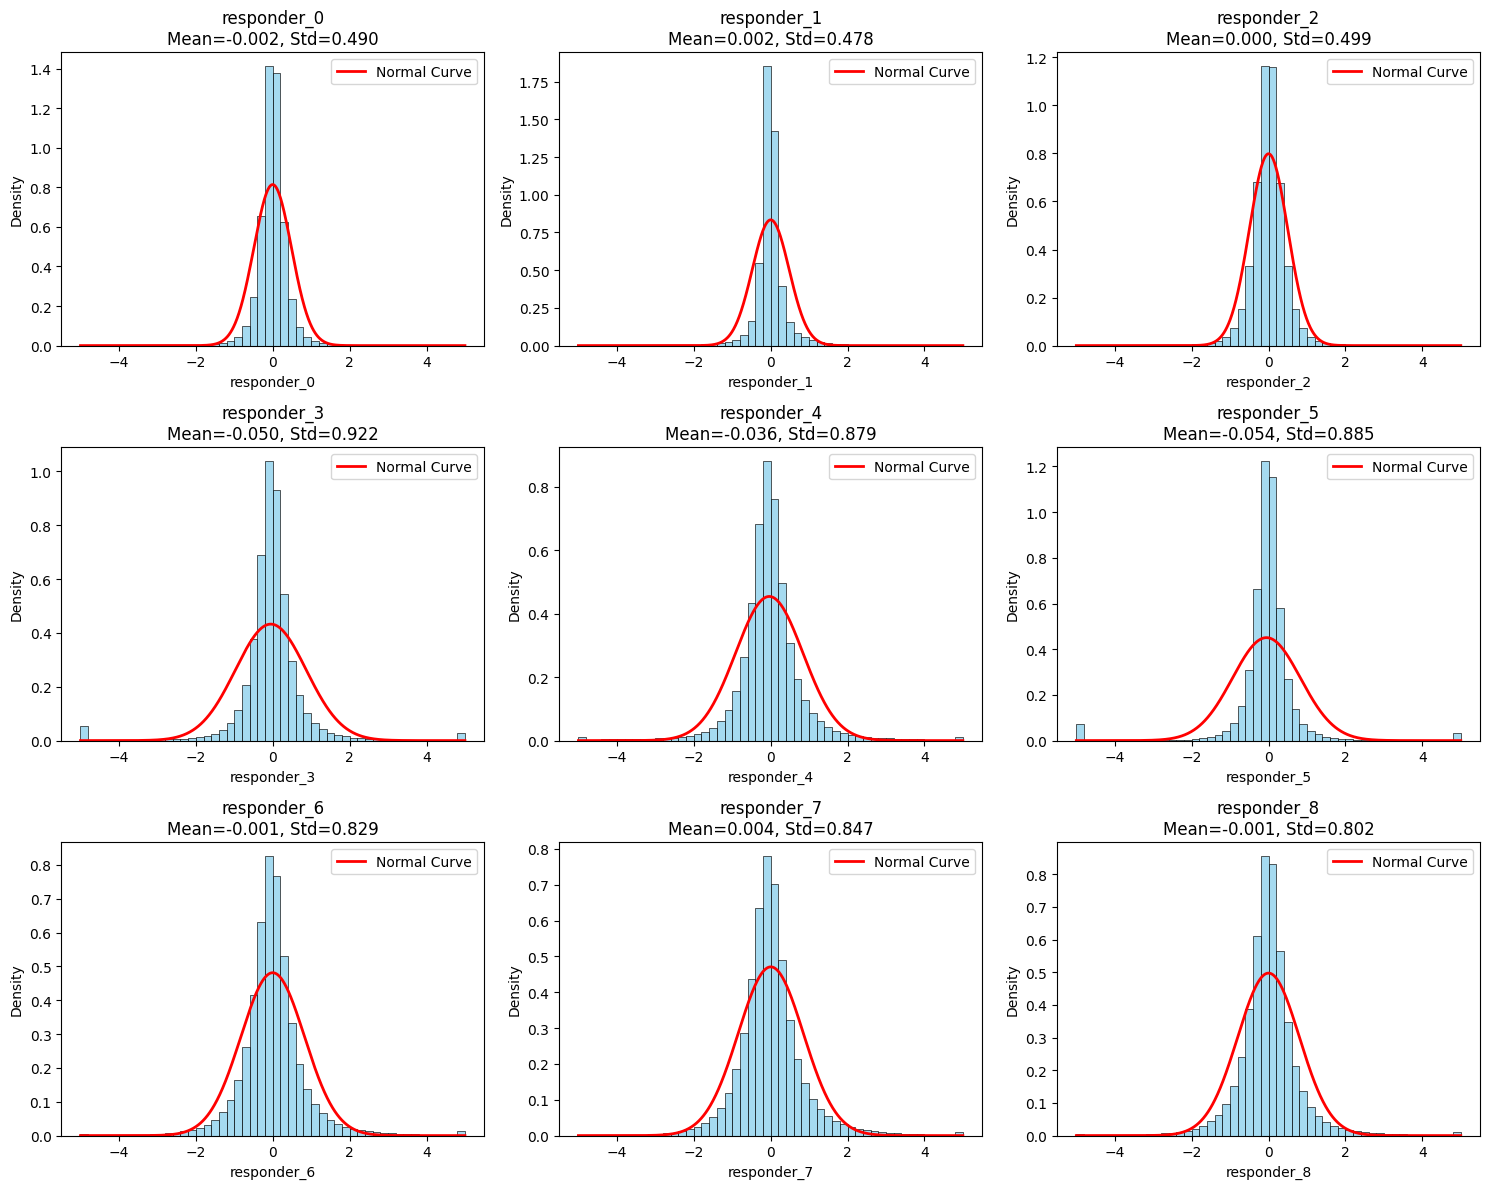

In [11]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
# Convert the array of the form (rows x columns) into a single list
axes = axes.flatten()     

for ax, resp in zip(axes, resp_cols):
    responders = train_df[resp].dropna()
    sns.histplot(responders, bins=50, stat="density", ax=ax, color="skyblue", edgecolor="black")
    
    # Normal dist
    mean, std = responders.mean(), responders.std()
    x = np.linspace(responders.min(), responders.max(), 1000)
    y = norm.pdf(x, mean, std)
    ax.plot(x, y, color="red", linewidth=2, label="Normal Curve")

    ax.set_title(f"{resp}\nMean={mean:.3f}, Std={std:.3f}")
    ax.legend()
    
plt.tight_layout()
plt.show()

**Our responders are  leptokurtic distribution that is mean we have sharper peak beacause most our data set around the mean and fatter tails than a normal distribution. These "fat tails" mean that extreme positive or negative events (outliers) are more likely to occur in a leptokurtic compared to a normal distribution.**

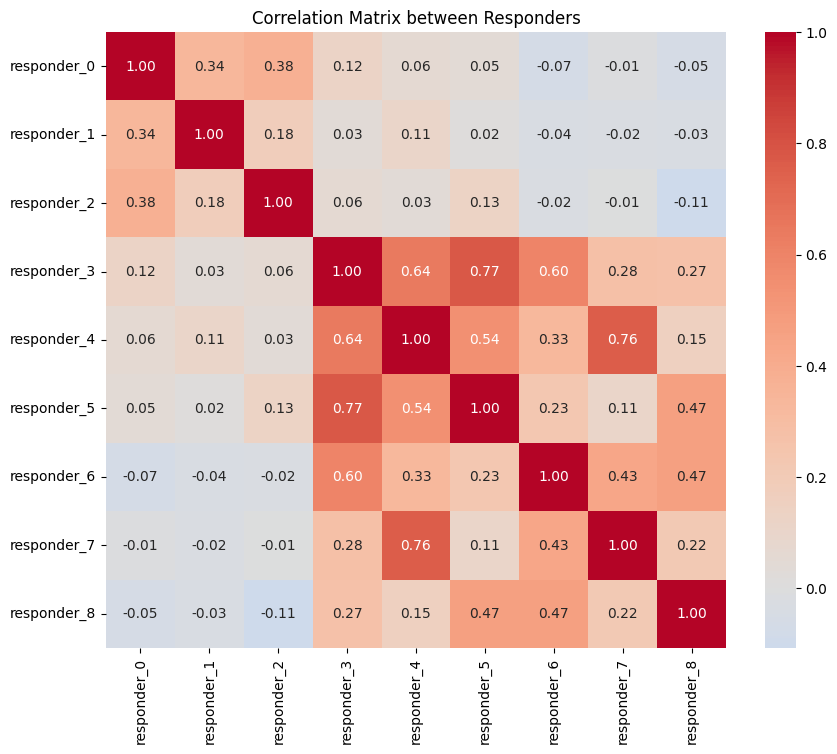

In [12]:
# Correlation Matrix
corr_matrix = train_df[resp_cols].corr()

# Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Correlation Matrix between Responders")
plt.show()

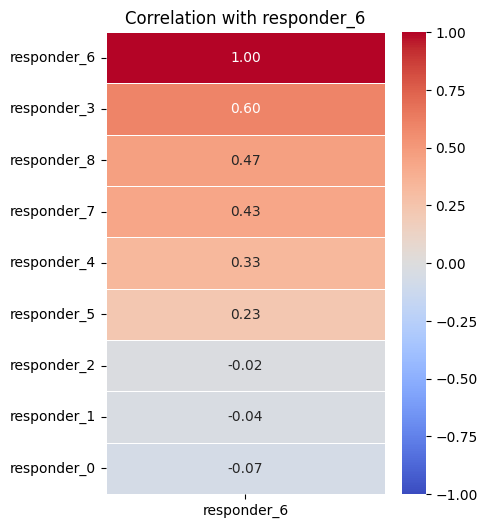

In [13]:
target = 'responder_6'
corr_with_target = train_df[resp_cols].corr()[target].sort_values(ascending=False)

plt.figure(figsize=(4.5, 6))
sns.heatmap(corr_with_target.to_frame(), cmap='coolwarm', vmin=-1, vmax=1,annot=True, fmt=".2f", linewidths=.5, cbar=True)
plt.title(f"Correlation with {target}")
plt.show()


In [16]:
'''# responders list except responder_6
numerical_features = sample_df.filter(regex='^responder_').columns.tolist()
numerical_features.remove('responder_6')

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    ax = axes[i]
    
    x = sample_df[col].values
    y = sample_df['responder_6'].values
    
    # hexbin plot
    hb = ax.hexbin(
        x, y,
        gridsize=40,
        cmap="viridis",
        mincnt=1
    )
    
    # fit linear regression line
    slope, intercept = np.polyfit(x, y, 1)
    ax.plot(
        np.sort(x),
        slope * np.sort(x) + intercept,
        color="red", linewidth=2, label="Trend"
    )
    
    # correlation coefficient
    r = np.corrcoef(x, y)[0, 1]
    ax.text(
    0.95, 0.95,               # top-right corner
    f"r = {r:.2f}",
    transform=ax.transAxes,
    fontsize=10,
    color="red",
    verticalalignment="top",
    horizontalalignment="right")
    
    ax.set_xlabel(col, fontsize=10)
    ax.set_ylabel("responder_6", fontsize=10)

plt.tight_layout()
'''

'# responders list except responder_6\nnumerical_features = sample_df.filter(regex=\'^responder_\').columns.tolist()\nnumerical_features.remove(\'responder_6\')\n\nfig, axes = plt.subplots(3, 3, figsize=(15, 15))\naxes = axes.flatten()\n\nfor i, col in enumerate(numerical_features):\n    ax = axes[i]\n    \n    x = sample_df[col].values\n    y = sample_df[\'responder_6\'].values\n    \n    # hexbin plot\n    hb = ax.hexbin(\n        x, y,\n        gridsize=40,\n        cmap="viridis",\n        mincnt=1\n    )\n    \n    # fit linear regression line\n    slope, intercept = np.polyfit(x, y, 1)\n    ax.plot(\n        np.sort(x),\n        slope * np.sort(x) + intercept,\n        color="red", linewidth=2, label="Trend"\n    )\n    \n    # correlation coefficient\n    r = np.corrcoef(x, y)[0, 1]\n    ax.text(\n    0.95, 0.95,               # top-right corner\n    f"r = {r:.2f}",\n    transform=ax.transAxes,\n    fontsize=10,\n    color="red",\n    verticalalignment="top",\n    horizontalalig

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 30000, number of used features: 8
[LightGBM] [Info] Start training from score -0.004845


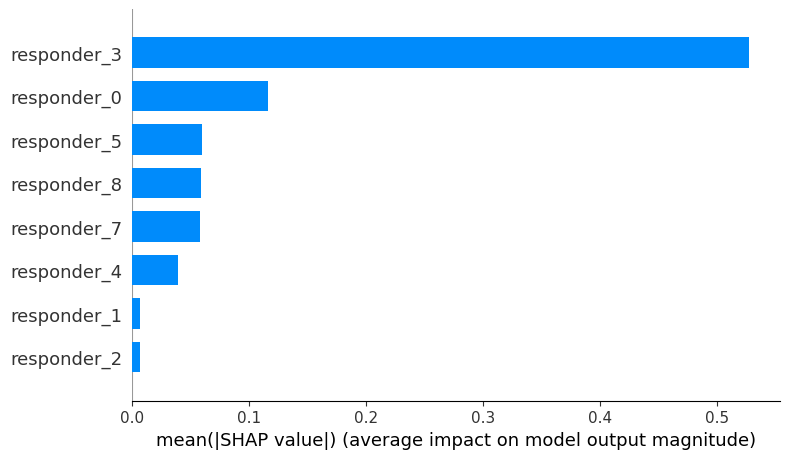

In [15]:
#We will use shap to know best responders columns help to predict responder_6

sample_df = train_df[resp_cols].sample(n=30000, random_state=42)

X = sample_df.drop(columns=["responder_6"])
y = sample_df["responder_6"]

# Model
model = lgb.LGBMRegressor(n_estimators=200, random_state=42, n_jobs=-1)
model.fit(X, y)

# نحسب قيم SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# نرسم Summary Plot
shap.summary_plot(shap_values, X, plot_type="bar", max_display=10)


**Best features for predict responder_6 is responder_0 and responder_3 and that Confirms a correlation that we find when we anaylsis responders_structure in responders.csv file**

In [59]:
# let's check auto correlation for responders and symbol_id
# unique_symbols
unique_symbols = train_df['symbol_id'].unique()
unique_symbols

array([ 1,  7,  9, 10, 14, 16, 19, 33,  0,  2, 13, 15, 38,  3, 12,  8, 17,
       34, 11, 30], dtype=int8)

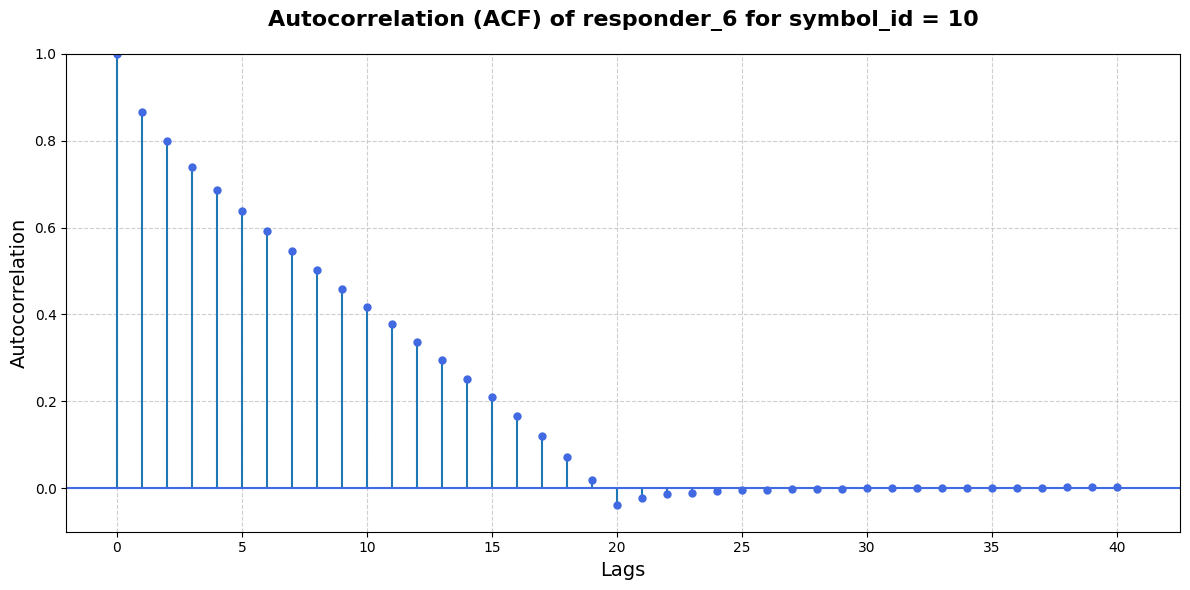

In [60]:
# Random choice
random.seed(42)  
chosen_symbol = random.choice(unique_symbols)

# Choice_symbol
symbol_data = train_df[train_df['symbol_id'] == chosen_symbol]
# Responder_6
target_series = symbol_data['responder_6'].dropna()

# ACF
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(target_series, lags=40, ax=ax, color="royalblue", alpha=0.8)


ax.set_title(f"Autocorrelation (ACF) of responder_6 for symbol_id = {chosen_symbol}", fontsize=16, fontweight="bold", pad=20)
ax.set_xlabel("Lags", fontsize=14)
ax.set_ylabel("Autocorrelation", fontsize=14)
ax.grid(True, linestyle="--", alpha=0.6)
plt.ylim(-0.1, 1)

plt.tight_layout()
plt.show()

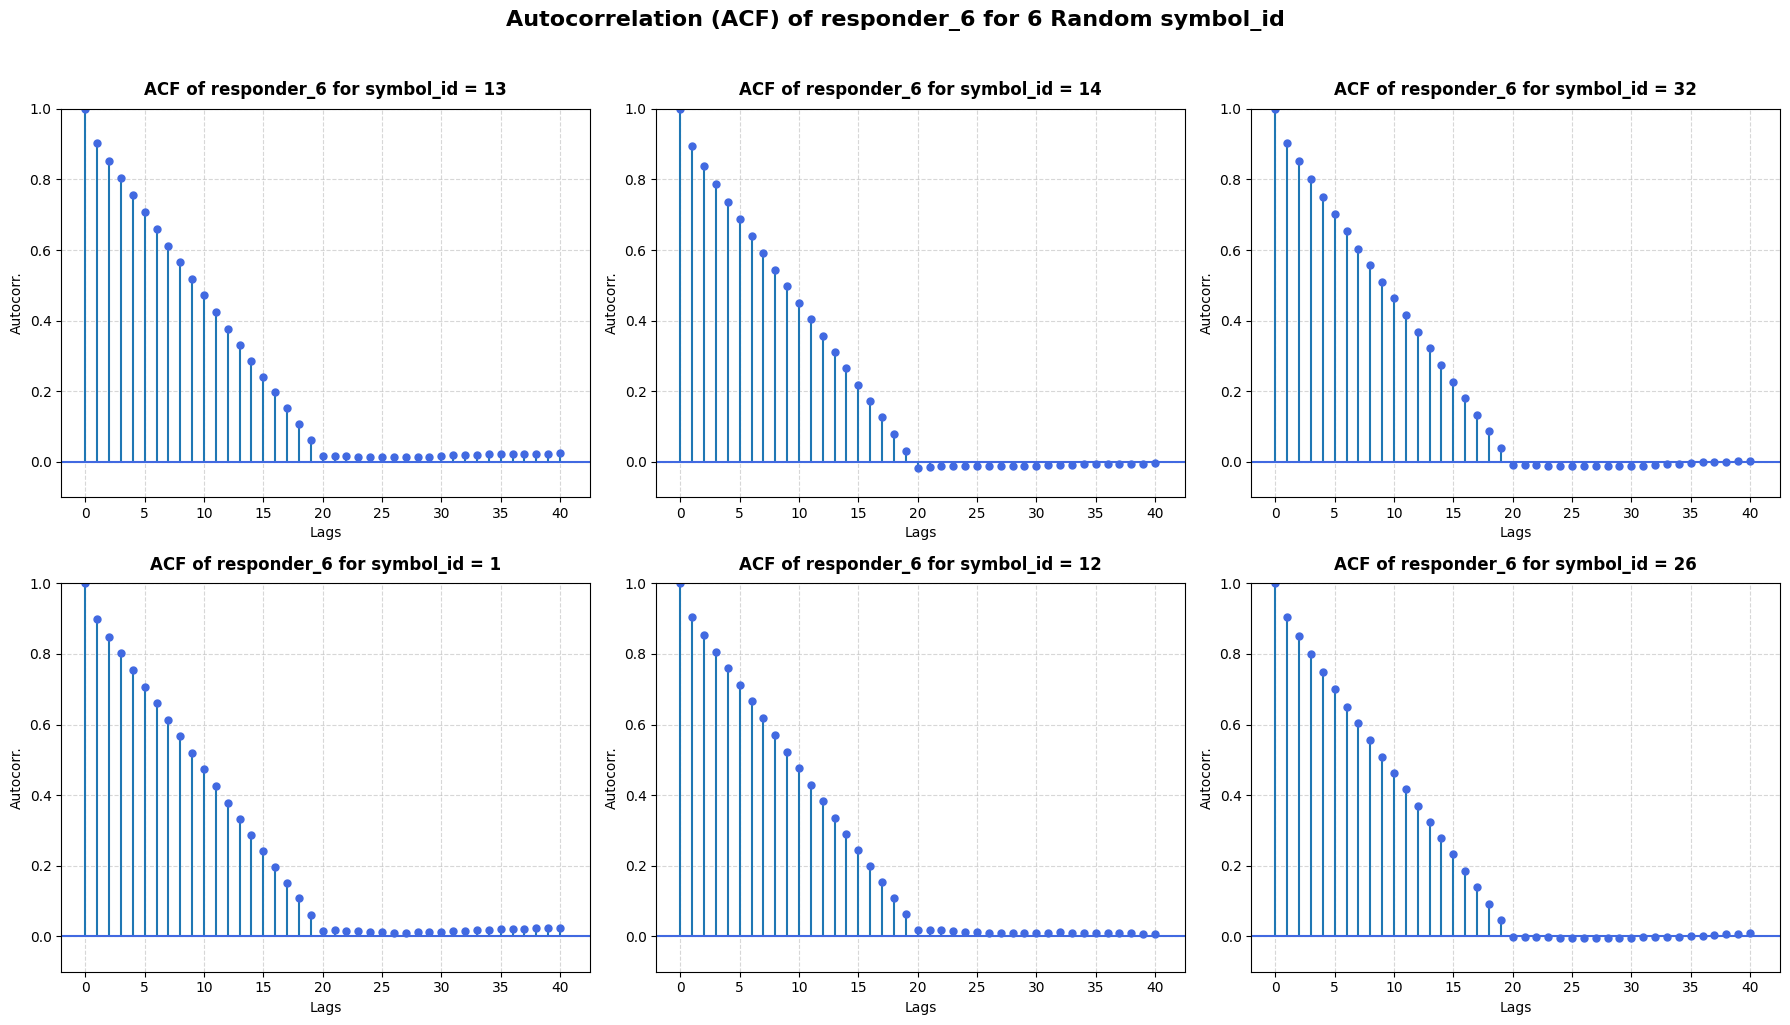

In [28]:
chosen_symbols = random.sample(list(unique_symbols), 6)  

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i,ax in zip(chosen_symbols,axes) :
    symbols_resp = train_df[train_df['symbol_id'] == i]
    target_series = symbols_resp['responder_6'].dropna()
    plot_acf(target_series, lags=40, ax=ax, color="royalblue", alpha=0.8)
    
    ax.set_title(f"ACF of responder_6 for symbol_id = {i}", fontsize=12, fontweight="bold", pad=10)
    ax.set_xlabel("Lags")
    ax.set_ylabel("Autocorr.")
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.set_ylim(-0.1, 1)
   
plt.suptitle("Autocorrelation (ACF) of responder_6 for 6 Random symbol_id", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

**We have a cutoff after lag 20 in all symbol_id i think responder_(6) is generted with MA(20) let's chek it**

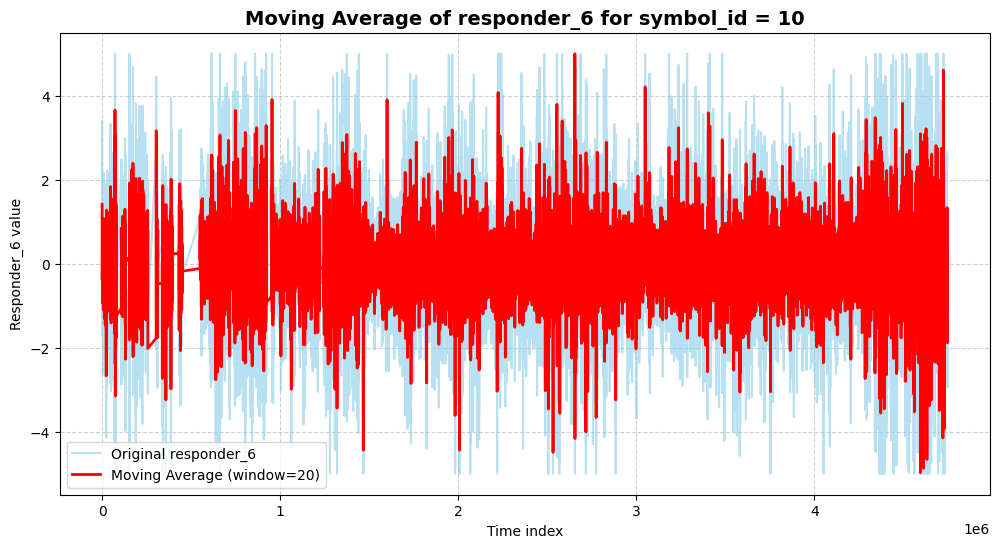

In [64]:
# Target
target_series = symbol_data['responder_6']

# Calculate Moving Average
window = 20
moving_avg = target_series.rolling(window=window).mean()

plt.figure(figsize=(12,6))
plt.plot(target_series, color='skyblue', alpha=0.6, label='Original responder_6')
plt.plot(moving_avg, color='red', linewidth=2, label=f'Moving Average (window={window})')

plt.title(f'Moving Average of responder_6 for symbol_id = {chosen_symbol}', fontsize=14, fontweight='bold')
plt.xlabel('Time index')
plt.ylabel('Responder_6 value')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

**Based on the ACF patterns, we can confidently say that responder_6 behaves like a Moving Average process with a window of 20.
 Therefore, we must shift responder_6 by +20 steps (t+20) to correctly align the target with its future value.
  Without this shift, we would be leaking future information into the present — causing data leakage.
  In other words, our model should learn to predict responder_6 at time (t+20), not the current value at time (t).**


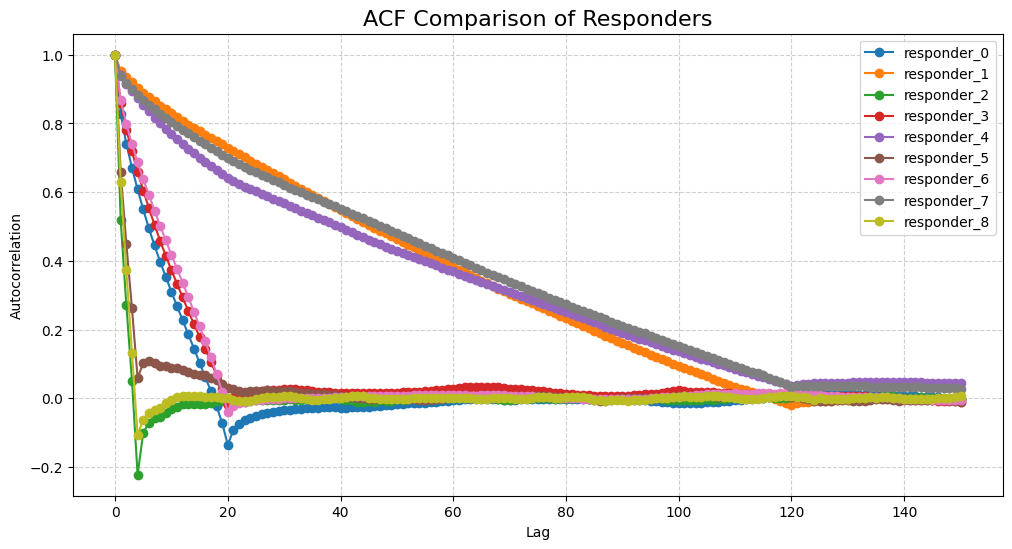

In [62]:
plt.figure(figsize=(12, 6))

for resp in resp_cols:
    # Compute autocorrelation values for each responder
    acf_values = acf(symbol_data[resp], nlags=150)
    plt.plot(acf_values, marker='o', label=resp)

plt.title("ACF Comparison of Responders", fontsize=16)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

###  ACF Analysis — Identifying the Moving Average Windows of Responders

By analyzing the **Autocorrelation Function (ACF)** for all responders, we notice distinct grouping patterns based on their temporal dependencies:

- **Responders (2, 5, 8)** → similar ACF decay patterns → **Moving Average window ≈ 4**  
- **Responders (0, 3, 6)** → smooth, slower ACF decay → **Moving Average window ≈ 20**  
- **Responders (1, 4, 7)** → very slow ACF decay → **Moving Average window ≈ 120**

These findings suggest that each group of responders is derived from the same underlying signal but smoothed with different **MA window sizes (4, 20, and 120)**.

---

### 🧩 Relation with Responders Structure (responders_structure.csv)

From the file `responders.csv`, we observe groups of responders that share the same **tag**, which aligns with the ACF-based grouping:

| Tag | Responders | Shared Properties |
|------|-------------|------------------|
| tag_0 | ['responder_0', 'responder_1', 'responder_2'] | Related baseline signal |
| tag_1 | ['responder_2', 'responder_5', 'responder_8'] | **MA(4)** family |
| tag_2 | ['responder_0', 'responder_3', 'responder_6'] | **MA(20)** family |
| tag_3 | ['responder_1', 'responder_4', 'responder_7'] | **MA(120)** family |
| tag_4 | ['responder_3', 'responder_4', 'responder_5'] | Cross-linked smoothers |

---

**Conclusion:**  
Responders sharing the same **tag** in the structure file tend to exhibit the same **autocorrelation behavior** and **moving average window length**.  
This strongly supports the theory that these responders are **different smoothed versions of the same base signal**, differing only in their temporal smoothing scales.

**Important Note — Shifting Responders to Avoid Data Leakage:
Since each responder behaves like a moving average of the future, we must shift each responder forward by its MA window size to align predictions correctly and avoid leaking future information during training:**

**MA(4) responders → shift by +4**

**MA(20) responders → shift by +20**

**MA(120) responders → shift by +120**

In [23]:
'''
acf_matrix = []
for resp in responders:
    acf_vals = acf(df_symbol1[resp], nlags=120)
    acf_matrix.append(acf_vals)

acf_df = pd.DataFrame(acf_matrix, index=responders)

plt.figure(figsize=(12,6))
sns.heatmap(acf_df, cmap="coolwarm", annot=False)
plt.title("ACF Heatmap of responders", fontsize=16)
plt.xlabel("Lags")
plt.ylabel("Responders")
plt.show()
'''

'\nacf_matrix = []\nfor resp in responders:\n    acf_vals = acf(df_symbol1[resp], nlags=120)\n    acf_matrix.append(acf_vals)\n\nacf_df = pd.DataFrame(acf_matrix, index=responders)\n\nplt.figure(figsize=(12,6))\nsns.heatmap(acf_df, cmap="coolwarm", annot=False)\nplt.title("ACF Heatmap of responders", fontsize=16)\nplt.xlabel("Lags")\nplt.ylabel("Responders")\nplt.show()\n'

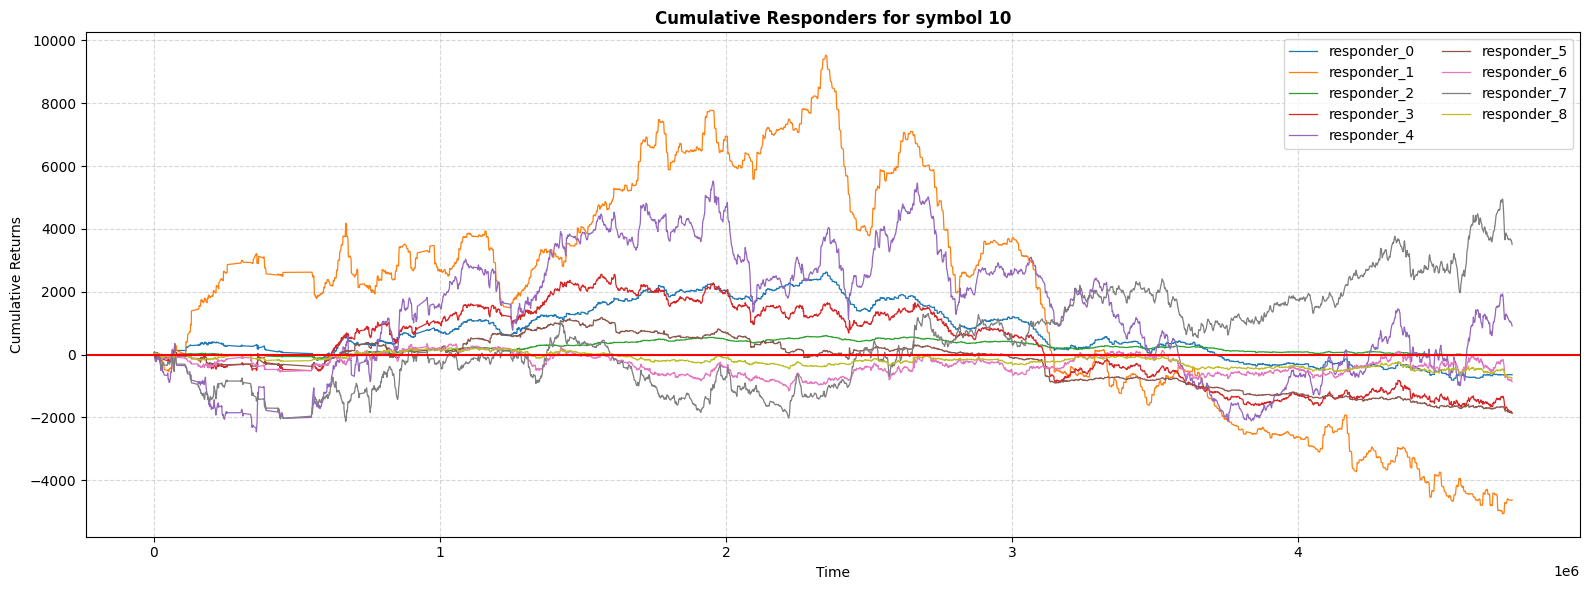

In [65]:
plt.figure(figsize=(16, 6))
step = max(1, len(symbol_data) // 5000)

for resp in resp_cols:
    x = symbol_data.index[::step]
    y = symbol_data[resp].cumsum()[::step]
    plt.plot(x, y, linewidth=0.9, label=resp)

plt.title(f'Cumulative Responders for symbol {chosen_symbol}', weight='bold')
plt.xlabel("Time")
plt.ylabel("Cumulative Returns")
plt.grid(ls='--', alpha=0.5)
plt.axhline(0, color='red')
plt.legend(ncol=2)
plt.tight_layout()
plt.show()


**We will make two plots to compare groups togather**
* **1- first plot will compare groups that have the same moving average(MA(4),MA(20),MA(120))**
* **2- second plot will compare groups by sorted((0,1,2),(3,4,5),(6,7,8))**

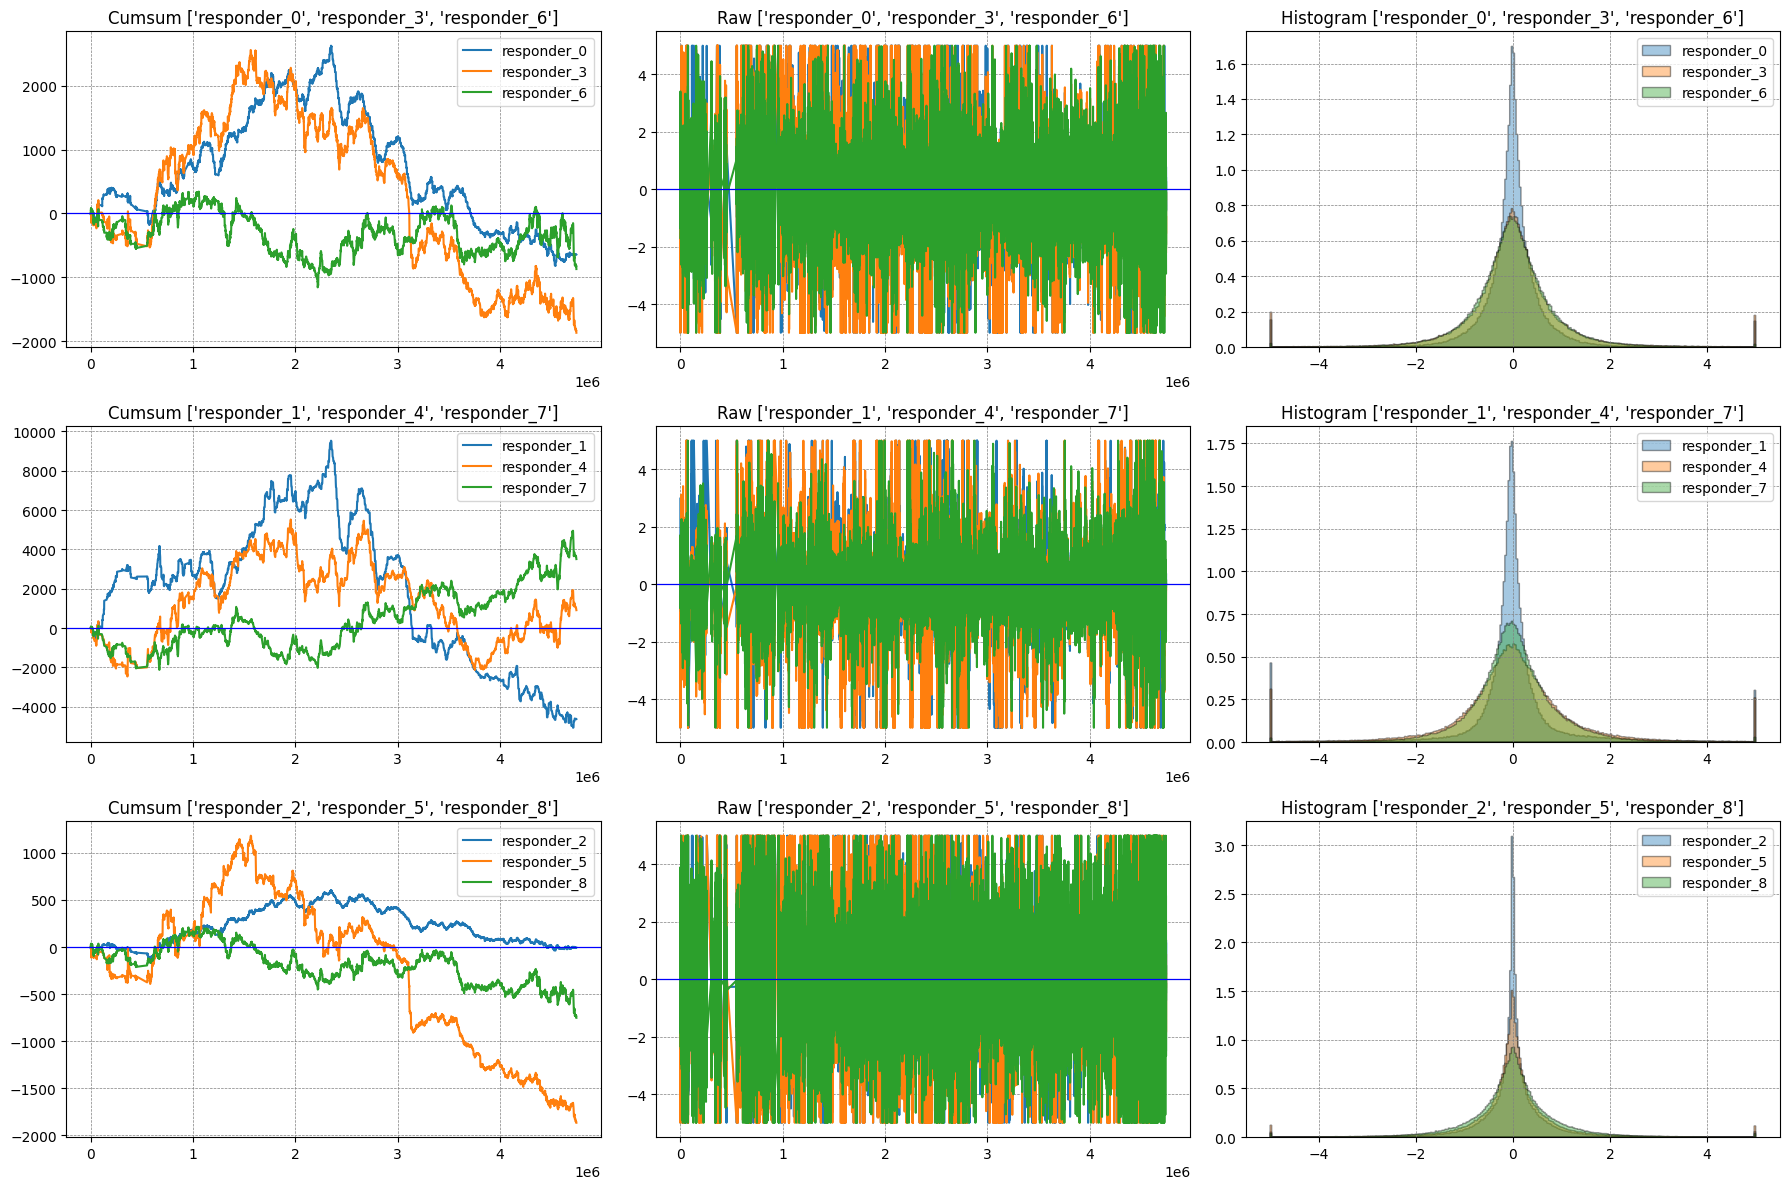

In [66]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

groups = [
    ['responder_0','responder_3','responder_6'],
    ['responder_1','responder_4','responder_7'],
    ['responder_2','responder_5','responder_8']
]

for row, group in enumerate(groups):

    # --- Cumulative Sum ---
    ax_cumsum = axes[row, 0]
    for col in group:
        x = symbol_data.index[::step]
        y = symbol_data[col].cumsum()[::step]
        ax_cumsum.plot(x, y, label=col)

    ax_cumsum.axhline(0, color='blue', linestyle='-', linewidth=0.9)
    ax_cumsum.grid(color="grey", linestyle="--", linewidth=0.5)
    ax_cumsum.legend()
    ax_cumsum.set_title(f"Cumsum {group}")

    # --- Raw Values ---
    ax_raw = axes[row, 1]
    for col in group:
        ax_raw.plot(symbol_data.index, symbol_data[col], label=col)

    ax_raw.axhline(0, color='blue', linestyle='-', linewidth=0.9)
    ax_raw.grid(color="grey", linestyle="--", linewidth=0.5)
    ax_raw.set_title(f"Raw {group}")

    # --- Histogram ---
    ax_hist = axes[row, 2]
    for col in group:
        data = symbol_data[col].dropna()
        ax_hist.hist(data, bins=300, alpha=0.4, density=True, histtype="stepfilled", label=col, edgecolor='black')

    ax_hist.grid(color="grey", linestyle="--", linewidth=0.5)
    ax_hist.legend()
    ax_hist.set_title(f"Histogram {group}")
    
plt.tight_layout()
plt.show()


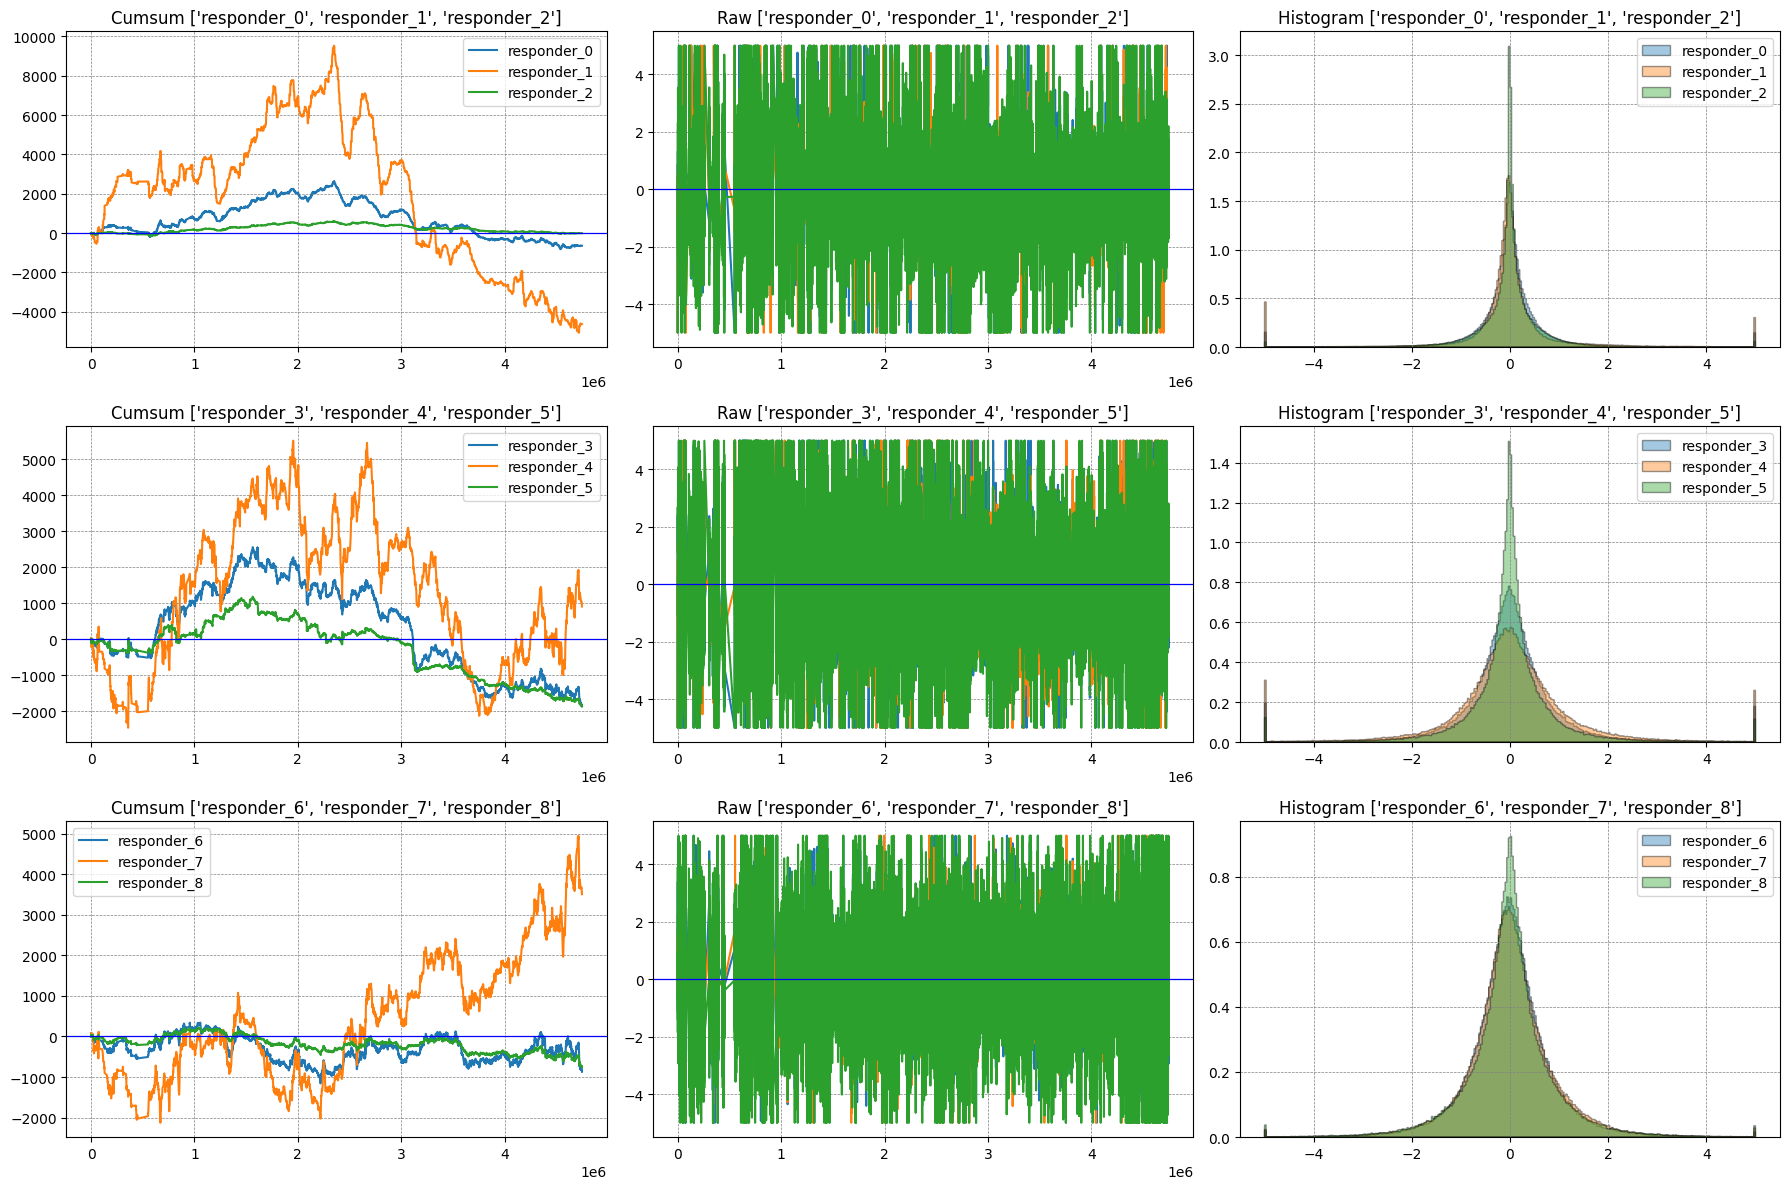

In [67]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

groups = [
    ['responder_0','responder_1','responder_2'],
    ['responder_3','responder_4','responder_5'],
    ['responder_6','responder_7','responder_8']
]

for row, group in enumerate(groups):

    # --- Cumulative Sum ---
    ax_cumsum = axes[row, 0]
    for col in group:
        x = symbol_data.index[::step]
        y = symbol_data[col].cumsum()[::step]
        ax_cumsum.plot(x, y, label=col)

    ax_cumsum.axhline(0, color='blue', linestyle='-', linewidth=0.9)
    ax_cumsum.grid(color="grey", linestyle="--", linewidth=0.5)
    ax_cumsum.legend()
    ax_cumsum.set_title(f"Cumsum {group}")

    # --- Raw Values ---
    ax_raw = axes[row, 1]
    for col in group:
        ax_raw.plot(symbol_data.index, symbol_data[col], label=col)

    ax_raw.axhline(0, color='blue', linestyle='-', linewidth=0.9)
    ax_raw.grid(color="grey", linestyle="--", linewidth=0.5)
    ax_raw.set_title(f"Raw {group}")

    # --- Histogram ---
    ax_hist = axes[row, 2]
    for col in group:
        target = symbol_data[col].dropna()
        ax_hist.hist(target, bins=300, alpha=0.4, density=True, histtype="stepfilled", label=col, edgecolor='black')

    ax_hist.grid(color="grey", linestyle="--", linewidth=0.5)
    ax_hist.legend()
    ax_hist.set_title(f"Histogram {group}")
    
plt.tight_layout()
plt.show()


**although groups here don't have the same MA but have almost the same raw signal**

**here although they are not have they same MA but we see alittle difference in variance and signals and the series go up and down togather.**
* **group 0,1,2  and 3,4,5  and 6,7,8 go up and down togather so let's make a clear plot to see this**

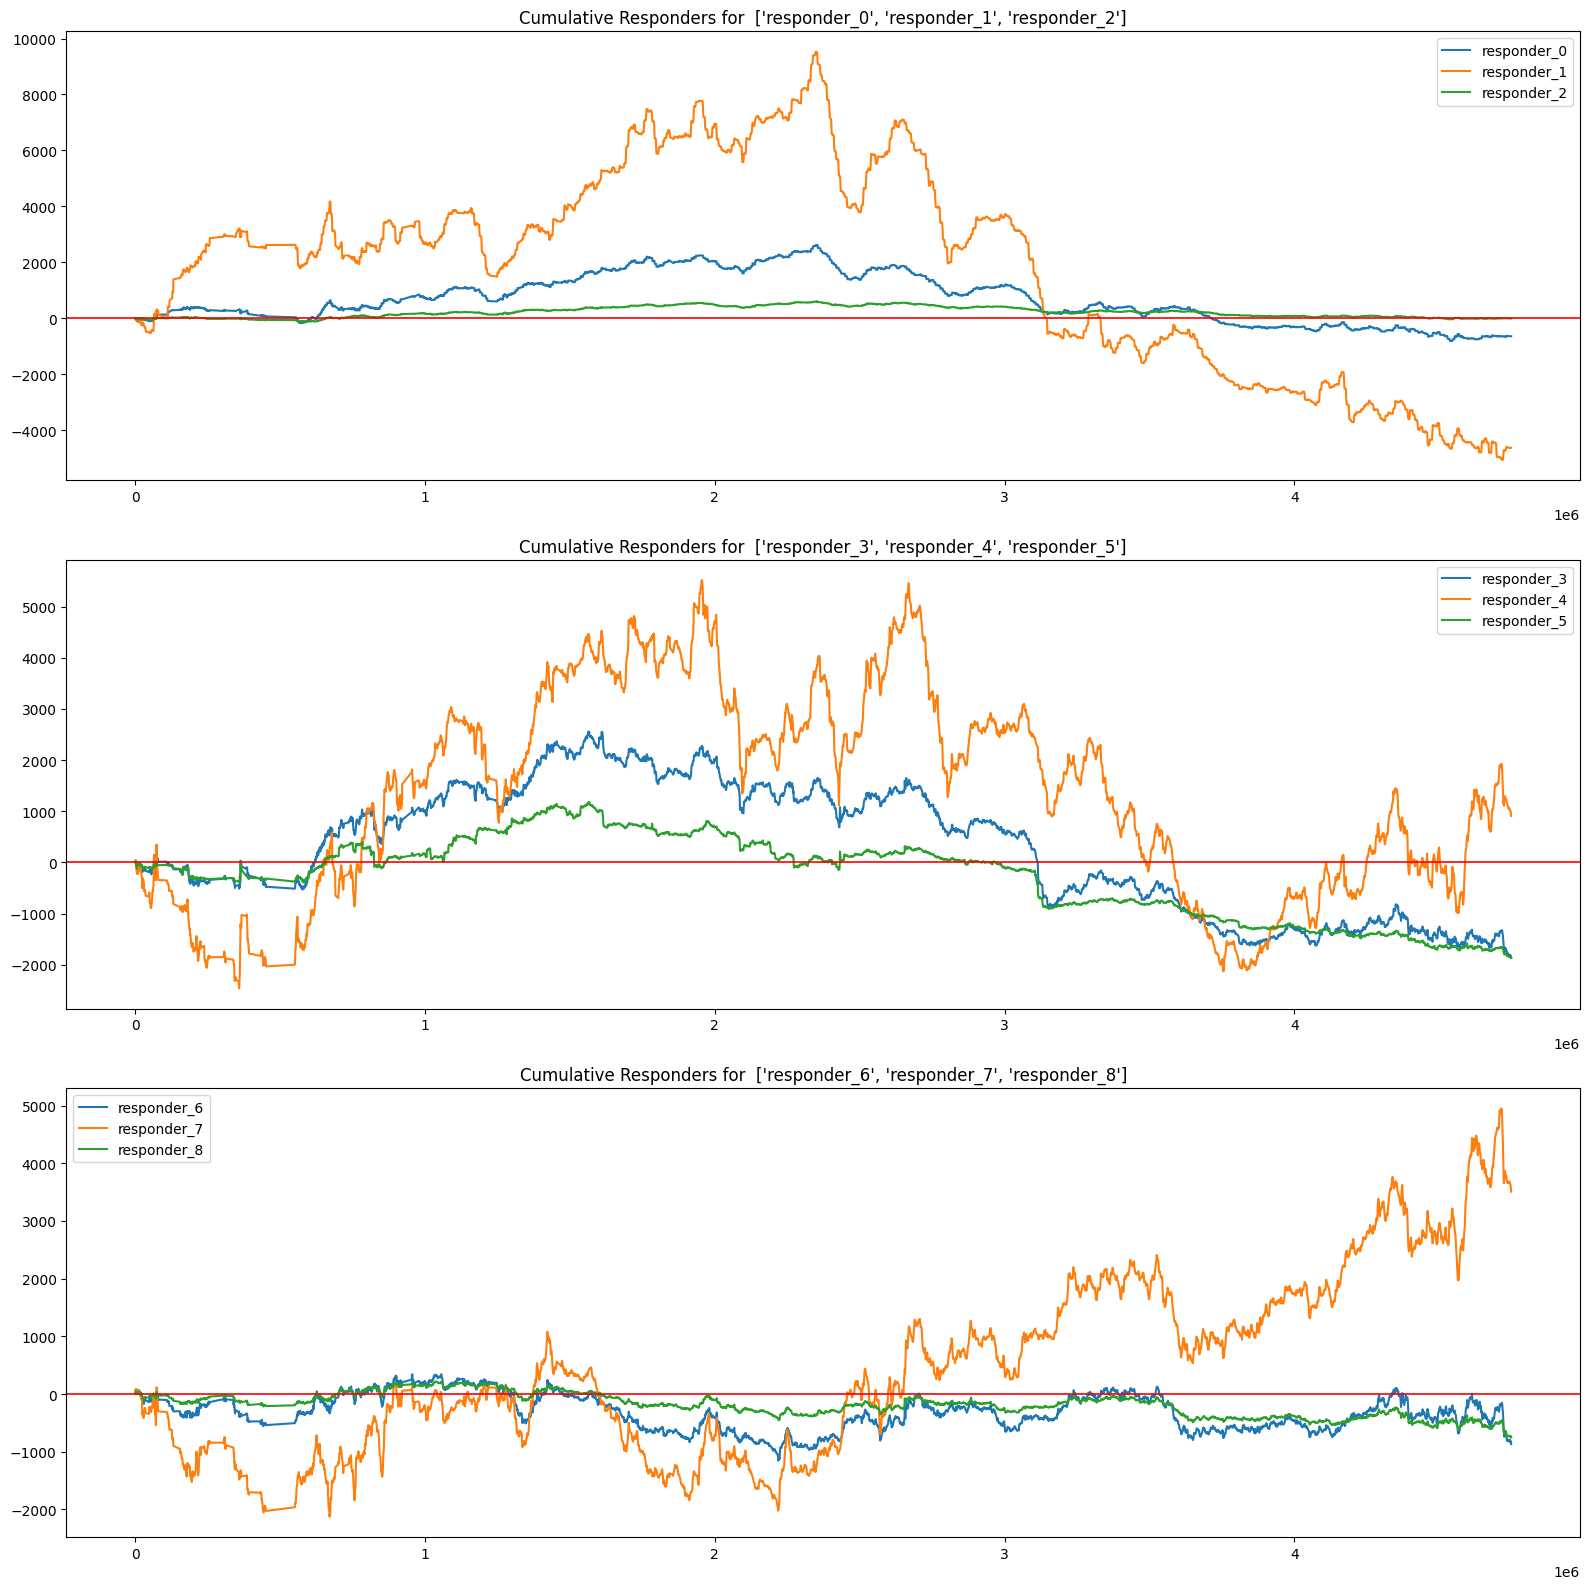

In [45]:
fig, axes = plt.subplots(3, 1, figsize=(16, 16))

for ax, group in zip(axes, groups):
    for col in group:
        x = symbol_data.index[::step]
        y = symbol_data[col].cumsum()[::step]
        ax.plot(x, y, label=col)

    ax.set_title(f"Cumulative Responders for  {group}")
    ax.axhline(0, color='red', linewidth=1.2)
    ax.legend()

plt.tight_layout()
plt.show()

**Even though the responder groups have different Moving Average (MA) windows, they still move in the same direction because they are all derived from the same underlying base signal — each one is just a smoothed or delayed version of it.**

* **MA(4) responders → capture short-term fluctuations (fast reaction).**

* **MA(20) responders → capture medium-term trends (moderate smoothing).**

* **MA(120) responders → capture long-term movements (slow response).**

**Interpretation:
All responders share the same "melody" (base signal) but with different “filters.”
That’s why they rise and fall together, even though their moving average windows differ —
they’re simply different time-horizon views of the same hidden process.**

**✅ Conclusion of EDA Responders Columns**

**All responders originate from the same underlying base signal, but each is smoothed over a different time horizon:**

* **MA(4) → captures short-term fluctuations**

* **MA(20) → captures medium-term trends**

* **MA(120) → captures long-term movements**

**Even though the MA windows differ, responders within the same or related tags move together because they represent different filtered versions of the same process.**

**To prevent data leakage, each responder should be shifted forward by its corresponding MA window:
+4, +20, or +120 steps, ensuring proper temporal alignment during training.**

##  2.2 - EDA Features Columns

**Let's start with understand the structure of features from csv file before anaylsis the columns in our train data**

In [11]:
features_structure = pd.read_csv('/kaggle/input/jane-street-real-time-market-data-forecasting/features.csv')
pd.reset_option("display.max_rows")
features_structure

feature  tag_0  tag_1  tag_2  tag_3  tag_4  tag_5  tag_6  tag_7  tag_8  \
0   feature_00  False  False   True  False  False  False  False  False  False   
1   feature_01  False  False   True  False  False  False  False  False  False   
2   feature_02  False  False   True  False  False  False  False  False  False   
3   feature_03  False  False   True  False  False  False  False  False  False   
4   feature_04  False  False   True  False  False  False  False  False  False   
..         ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
74  feature_74  False  False  False  False  False  False  False  False   True   
75  feature_75  False  False  False  False  False  False  False  False   True   
76  feature_76  False  False  False  False  False  False  False  False   True   
77  feature_77  False  False  False  False  False  False  False  False   True   
78  feature_78  False  False  False  False  False  False  False  False   True   

    tag_9  tag_10  tag_11  tag_12  tag_13  tag_14  tag_15  tag_16  
0   False   False   False   False   False    True   False    True  
1   False   False   False   False    True    True   False    True  
2   False   False   False    True   False   False   False    True  
3   False   False   False   False    True   False   False    True  
4   False   False   False    True    True   False   False    True  
..    ...     ...     ...     ...     ...     ...     ...     ...  
74  False   False   False   False   False    True   False   False  
75  False   False   False    True   False   False   False   False  
76  False   False   False    True   False   False   False   False  
77  False   False   False   False    True   False   False   False  
78  False   False   False   False    True   False   False   False  

[79 rows x 18 columns]

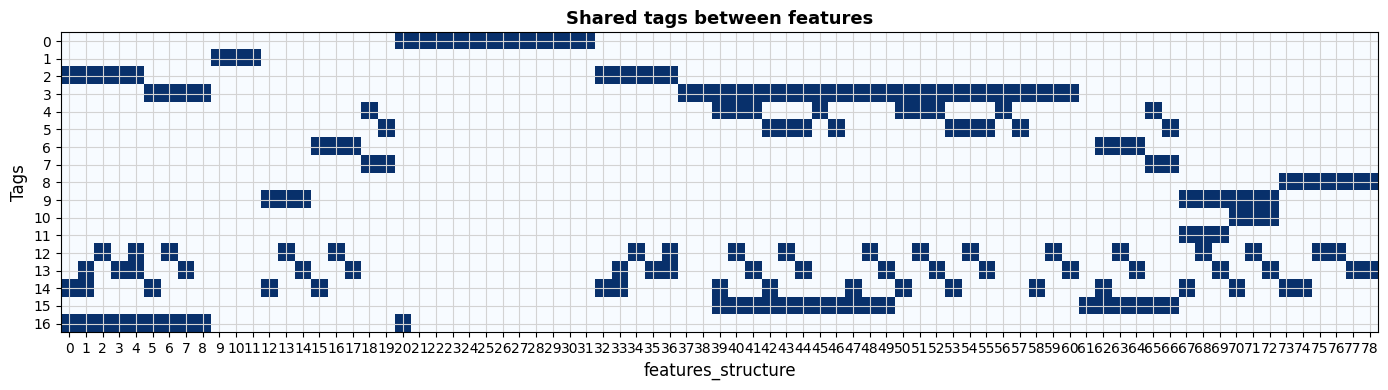

In [12]:
# PLot shared tags between features
fig, ax = plt.subplots(figsize=(14,4))
ax.imshow(features_structure.iloc[:, 1:].T, cmap="Blues", aspect="auto")

# x-axis: features
ax.set_xticks(np.arange(features_structure.shape[0]))
# y-axis: tags
ax.set_yticks(np.arange(features_structure.shape[1]-1))

plt.title("Shared tags between features", fontsize=13, fontweight="bold")
ax.set_xlabel("features_structure", fontsize=12)
ax.set_ylabel("Tags", fontsize=12)
plt.grid(color = 'lightgrey')
plt.tight_layout()
plt.show()

In [13]:
#Groups of responders sharing the same tag
features_structure.set_index("feature", inplace=True)

groups = []
for tag in features_structure.columns:
    feature_group = features_structure.index[features_structure[tag]].tolist()
    groups.append((tag, feature_group))

print("=== Groups of features sharing the same tag ===\n")
for tag, feature_group in groups:
    print(f"{tag}: {feature_group}\n")
    print ('------------------------------------------------------------')

=== Groups of features sharing the same tag ===

tag_0: ['feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31']

------------------------------------------------------------
tag_1: ['feature_09', 'feature_10', 'feature_11']

------------------------------------------------------------
tag_2: ['feature_00', 'feature_01', 'feature_02', 'feature_03', 'feature_04', 'feature_32', 'feature_33', 'feature_34', 'feature_35', 'feature_36']

------------------------------------------------------------
tag_3: ['feature_05', 'feature_06', 'feature_07', 'feature_08', 'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44', 'feature_45', 'feature_46', 'feature_47', 'feature_48', 'feature_49', 'feature_50', 'feature_51', 'feature_52', 'feature_53', 'feature_54', 'feature_55', 'feature_56', 'feature_57', 'feature_58', 'feature_59', 'feat

In [16]:
#Create a unique pattern for each feature based on the tags
tag_pattern = features_structure.astype(int).astype(str).agg(''.join, axis=1)

#Grouping features that share the same pattern
groups = tag_pattern.groupby(tag_pattern).groups

filtered_groups = [v for v in groups.values() if len(v) > 1]

for i, z in enumerate(filtered_groups):
        print(f'group_{i+1}: {list(z)}')

group_1: ['feature_73', 'feature_74']
group_2: ['feature_77', 'feature_78']
group_3: ['feature_75', 'feature_76']
group_4: ['feature_37', 'feature_38']
group_5: ['feature_09', 'feature_10', 'feature_11']
group_6: ['feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31']


In [8]:
features_structure.drop(columns=["tag_pattern"], inplace=True)

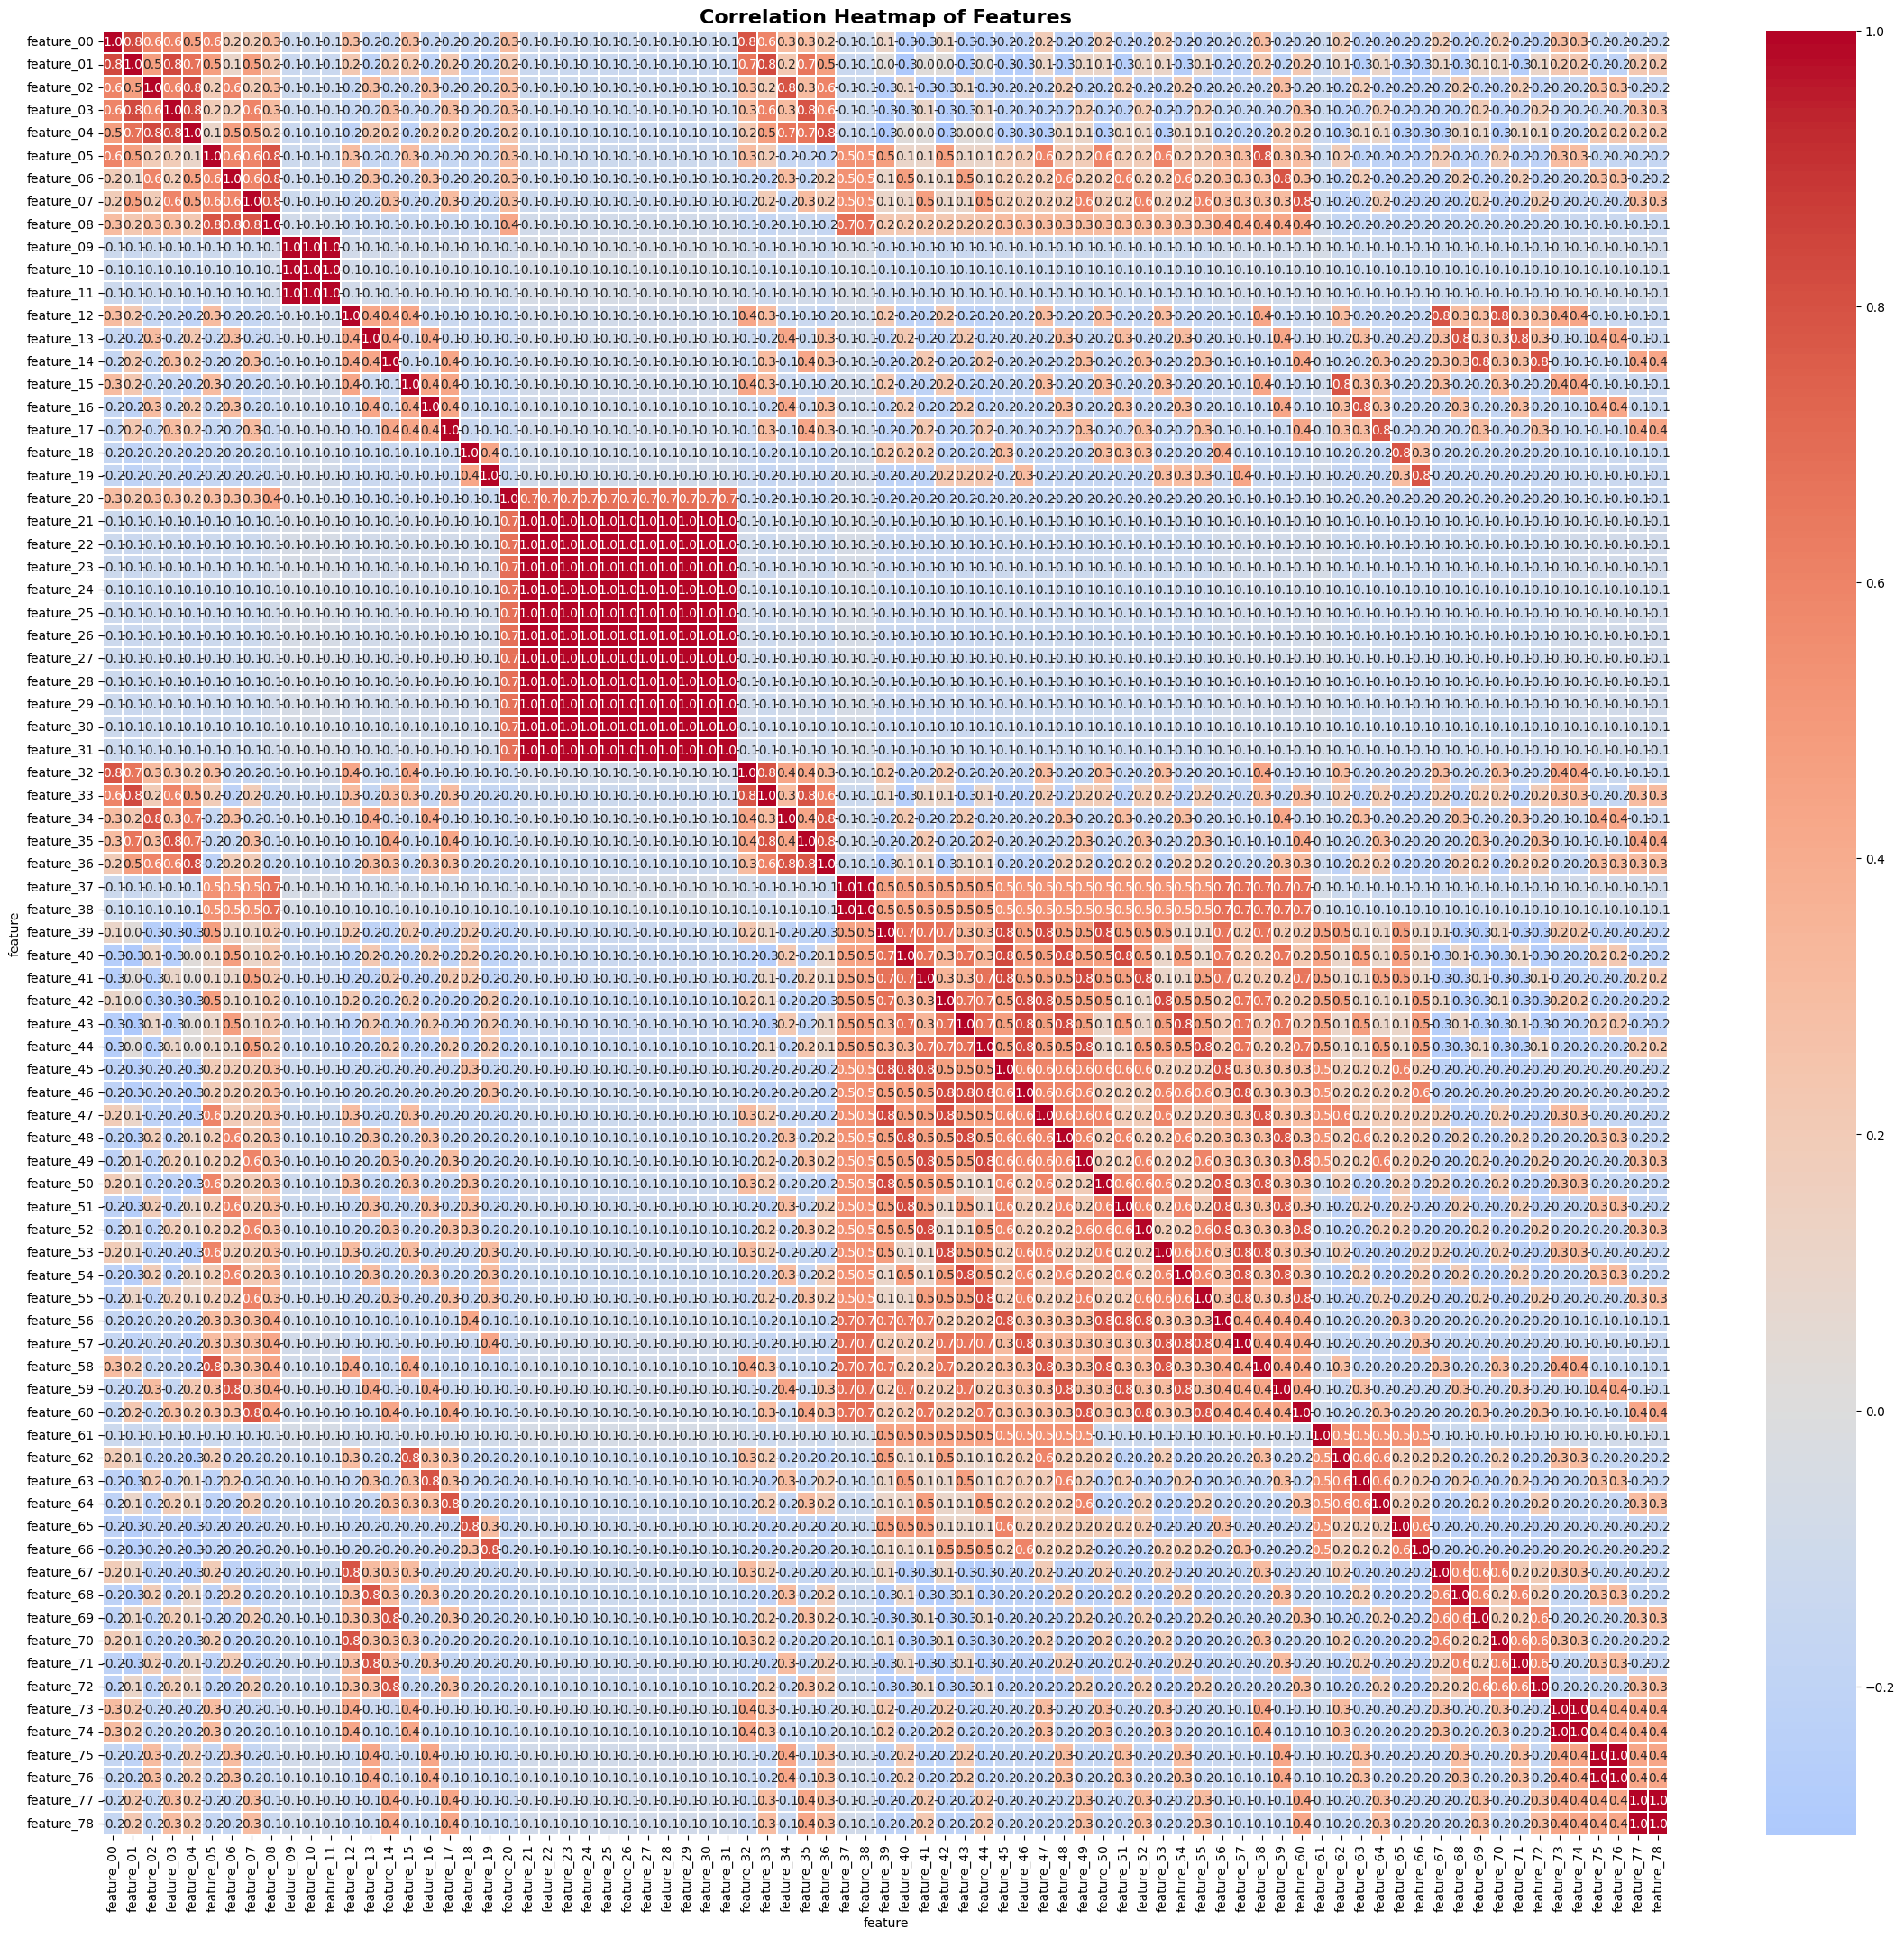

In [8]:
# Correlation Matrix
correlation_matrix = features_structure.T.corr()
# Heatmap
plt.figure(figsize=(28,26))
sns.heatmap(correlation_matrix,cmap="coolwarm",center=0,linewidths=0.1,fmt=".1f",annot=True)
plt.title("Correlation Heatmap of Features", fontsize=16, fontweight="bold")
plt.show()

**AS we see features which have the same group which match all tags are correlated approximately 1 for example**
1. group_1: ['feature_73', 'feature_74']
1. group_2: ['feature_77', 'feature_78']
1. group_3: ['feature_75', 'feature_76']
1. group_4: ['feature_37', 'feature_38']
1. group_5: ['feature_09', 'feature_10', 'feature_11']
1. group_6: ['feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31']
* **so we can drop features that are correlated approximately 1 and leave only one feature to reprsent the group or make PCA for the group or use columns to fill missing values column in the same group**

**After finished analysis of features_structure in features.csv file let's go to analysis features in train_df**

In [3]:
features_cols = train_df.filter(like="feature_").columns

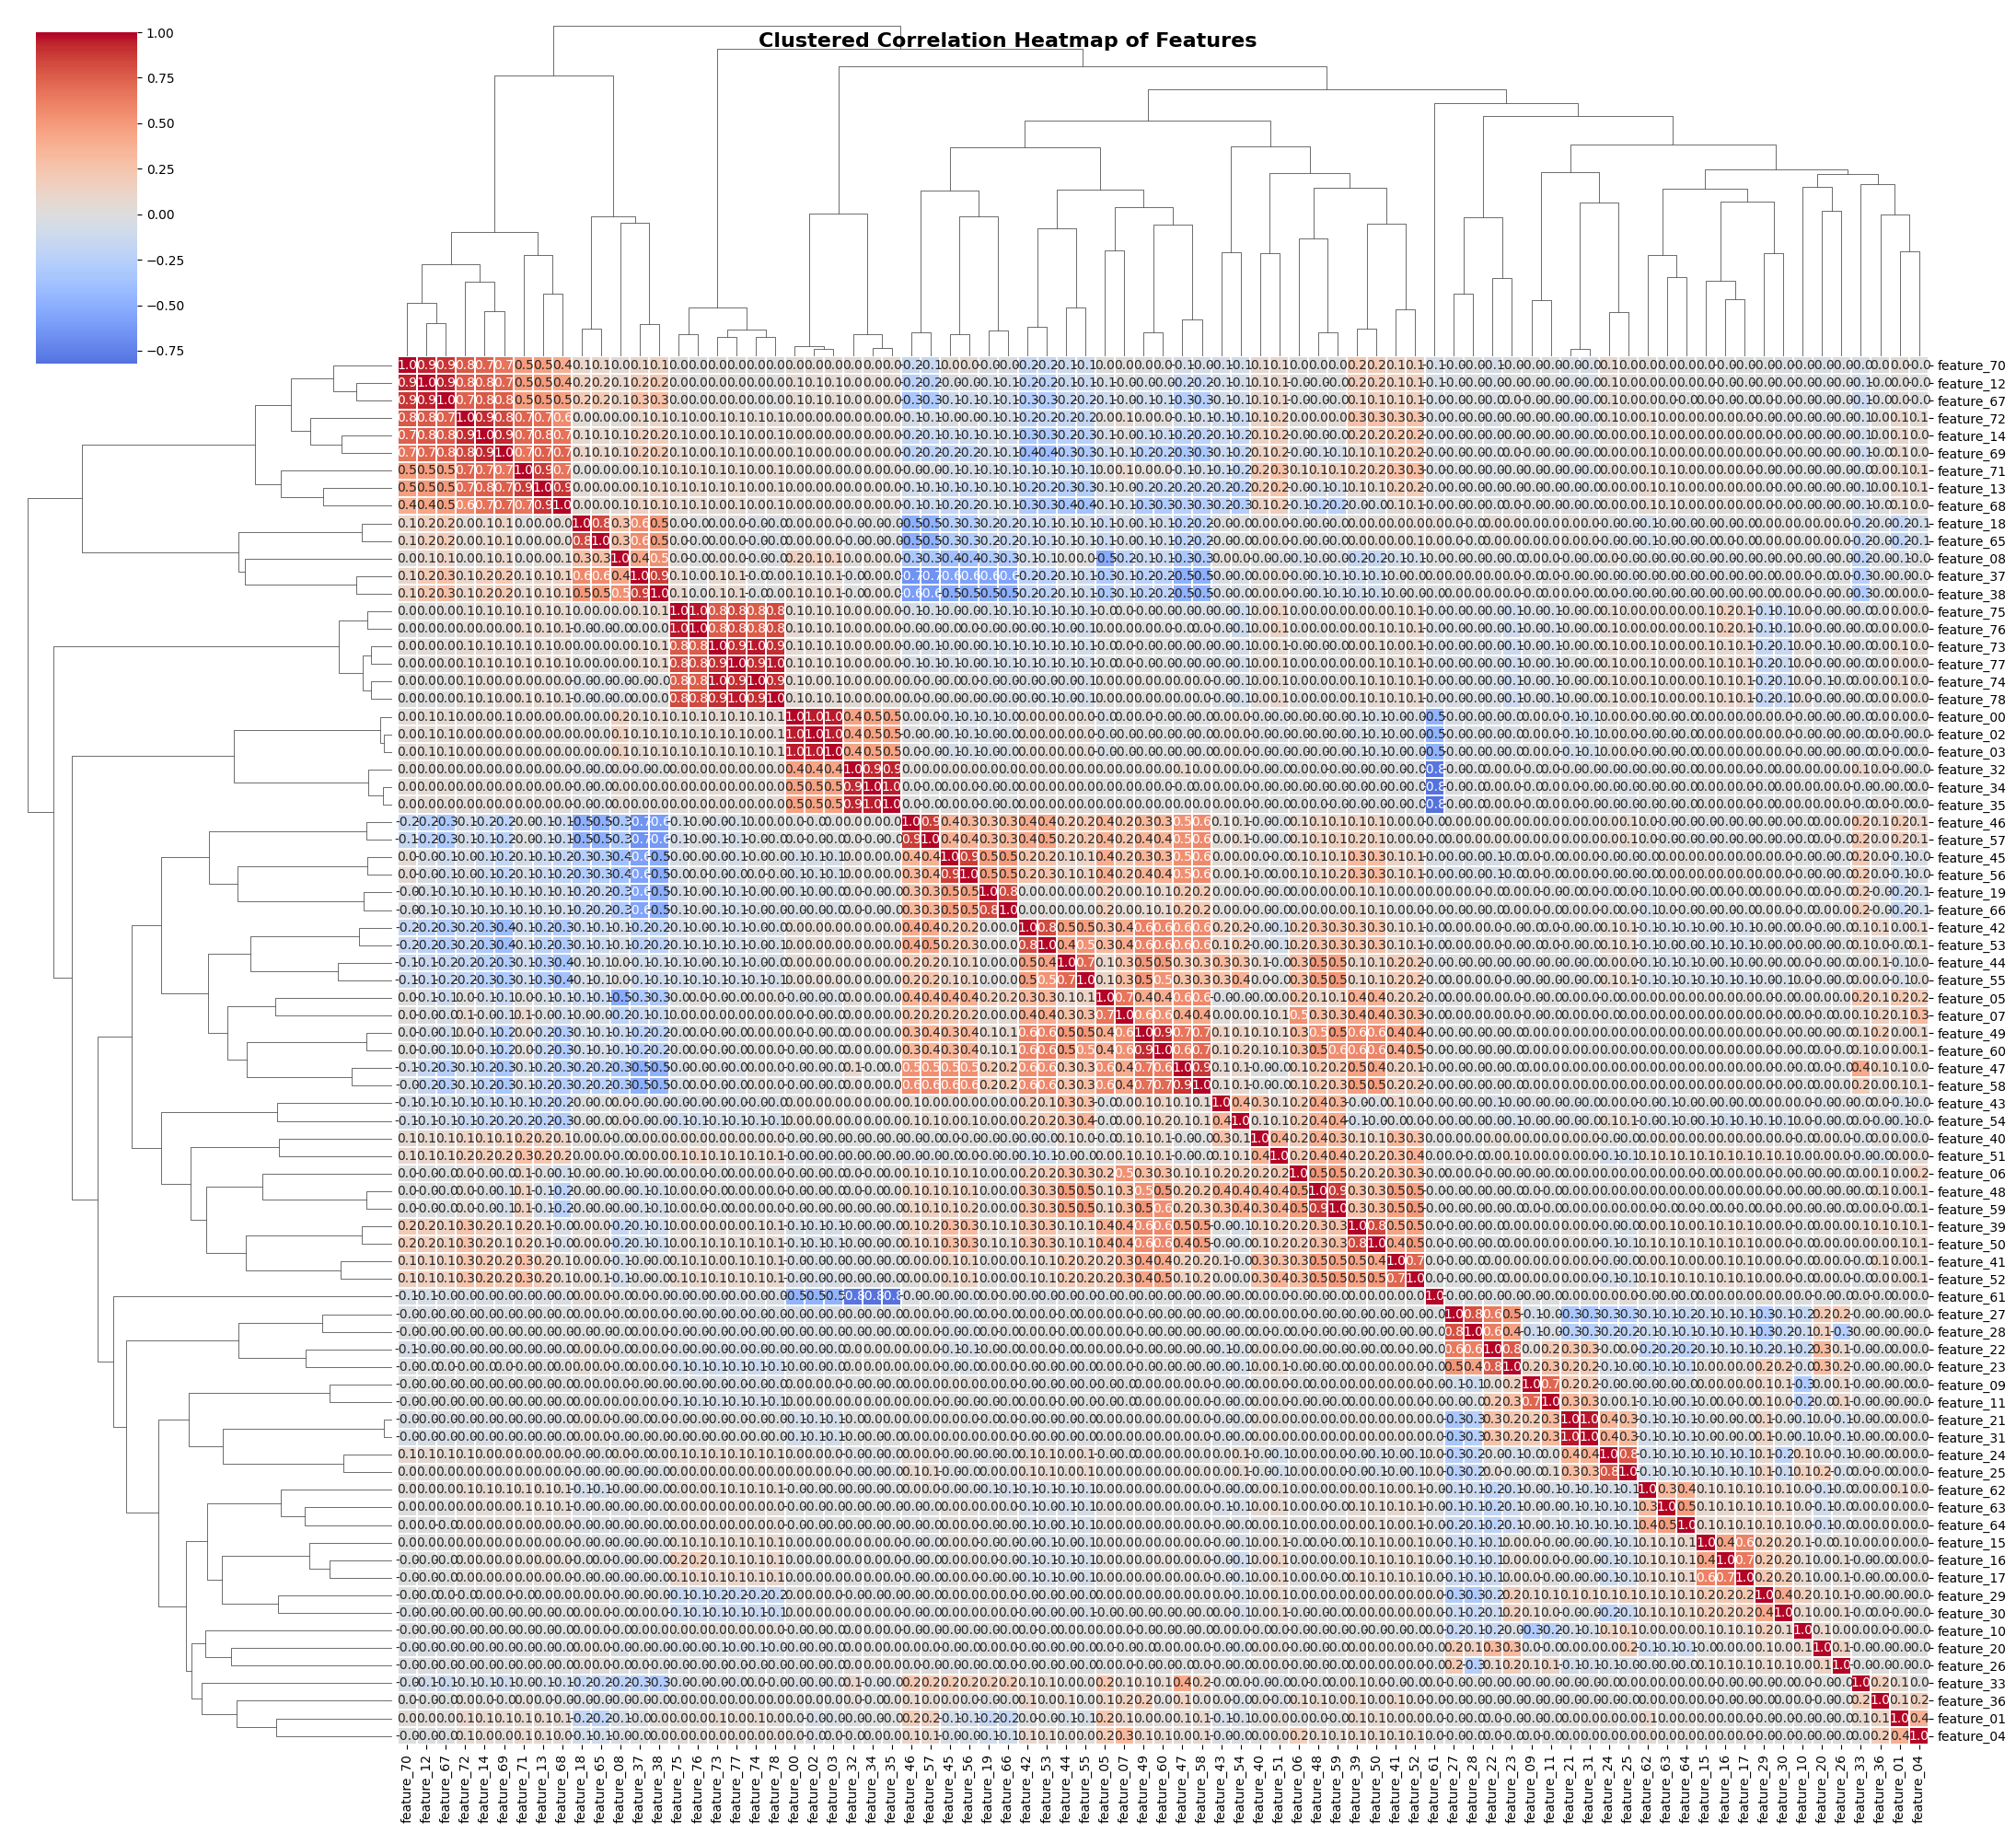

In [4]:
corr_matrix = train_df[features_cols].corr()
sns.clustermap(corr_matrix,cmap="coolwarm",center=0,linewidths=0.1,figsize=(22,20),fmt=".1f",annot=True)
plt.suptitle("Clustered Correlation Heatmap of Features", fontsize=16, fontweight="bold")
plt.show()

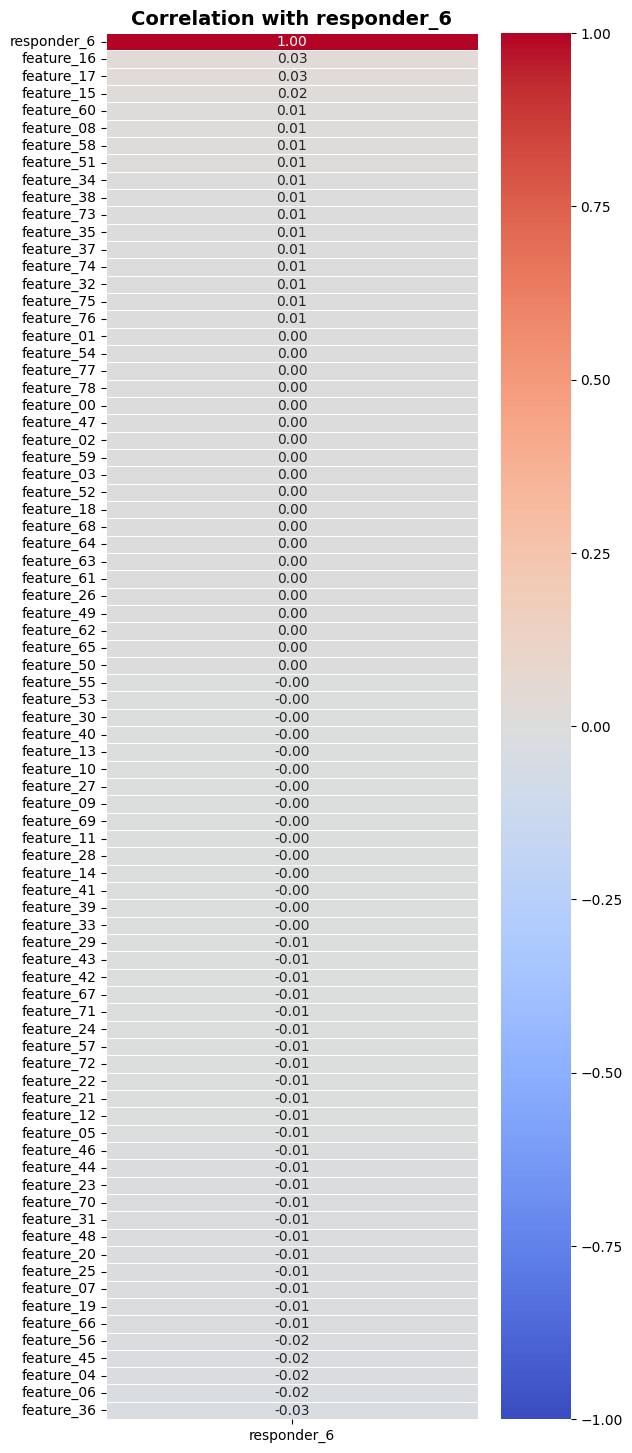

In [6]:
target_col = 'responder_6'
corr_with_target = train_df[features_cols.tolist() + [target_col]].corr()[target_col].sort_values(ascending=False)

plt.figure(figsize=(6, 18))
sns.heatmap(corr_with_target.to_frame(), cmap='coolwarm', vmin=-1, vmax=1,annot=True, fmt=".2f", linewidths=.5, cbar=True)
plt.title(f"Correlation with {target_col}", fontsize=14, fontweight="bold")
plt.show()


In [3]:
target_col = "responder_6"
weight_col = "weight"
features_cols = train_df.filter(like="feature_").columns

#Time segmentation within each symbol id
train_list, test_list = [], []

for symbol, df_symbol in tqdm(train_df.groupby("symbol_id", group_keys=False), desc="Splitting by symbol_id"):
    df_symbol = df_symbol.sort_values(["date_id", "time_id"])  
    split_index = int(len(df_symbol) * 0.8)
    train_list.append(df_symbol.iloc[:split_index])
    test_list.append(df_symbol.iloc[split_index:])

train_data = pd.concat(train_list, ignore_index=True)
test_data = pd.concat(test_list, ignore_index=True)

print(f"✅ Train shape: {train_data.shape}")
print(f"✅ Test shape: {test_data.shape}")
print(f"🕓 Train date range: {train_data['date_id'].min()} → {train_data['date_id'].max()}")
print(f"🕓 Test date range: {test_data['date_id'].min()} → {test_data['date_id'].max()}")

# X,y,w
X_train = train_data[features_cols]
y_train = train_data[target_col]
w_train = train_data[weight_col]

X_test = test_data[features_cols]
y_test = test_data[target_col]
w_test = test_data[weight_col]

Splitting by symbol_id: 100%|██████████| 39/39 [00:04<00:00,  8.55it/s]


✅ Train shape: (5019641, 92)
✅ Test shape: (1254935, 92)
🕓 Train date range: 1530 → 1666
🕓 Test date range: 1656 → 1698


In [4]:
# Weighted Zero-Mean R²
def weighted_zero_mean_r2_np(y_true, y_pred, weights):
    y_true_zm = y_true - np.average(y_true, weights=weights)
    y_pred_zm = y_pred - np.average(y_pred, weights=weights)
    numerator = np.sum(weights * (y_true_zm - y_pred_zm) ** 2)
    denominator = np.sum(weights * (y_true_zm) ** 2)
    return 1 - numerator / denominator

def weighted_zero_mean_r2_lgb(y_pred, dataset):
    """Custom version for LightGBM (feval)"""
    y_true = dataset.get_label()
    weights = dataset.get_weight()
    y_true_zm = y_true - np.average(y_true, weights=weights)
    y_pred_zm = y_pred - np.average(y_pred, weights=weights)
    numerator = np.sum(weights * (y_true_zm - y_pred_zm) ** 2)
    denominator = np.sum(weights * (y_true_zm) ** 2)
    r2 = 1 - numerator / denominator
    return "weighted_zero_mean_r2", r2, True  


In [5]:
# Train LightGBM model (Regression)
train_dataset = lgb.Dataset(X_train, label=y_train, weight=w_train)
test_dataset = lgb.Dataset(X_test, label=y_test, weight=w_test)

params = {
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "max_depth": -1,
    "seed": 42
}

evals_result = {}

model = lgb.train(
    params,
    train_set=train_dataset,
    valid_sets=[test_dataset],
    num_boost_round=300,
    feval=weighted_zero_mean_r2_lgb,
    callbacks=[lgb.record_evaluation(evals_result)]
)

y_pred = model.predict(X_test)
rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))
r2_weighted = weighted_zero_mean_r2_np(y_test.values, y_pred, w_test.values)

print(f"RMSE: {rmse:.6f}")
print(f"Weighted Zero-Mean R²: {r2_weighted:.6f}")

RMSE: 0.765543
Weighted Zero-Mean R²: 0.002158


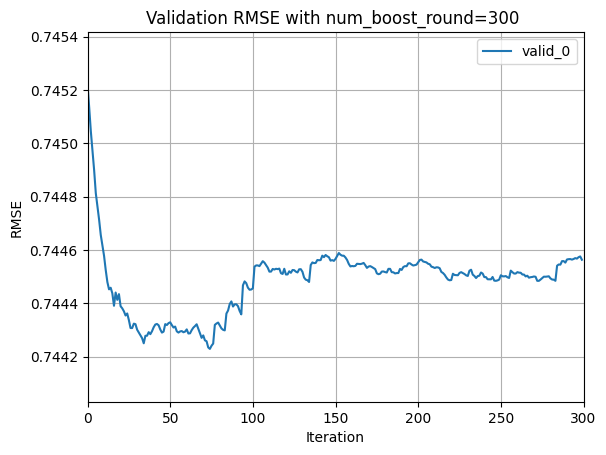

In [6]:
lgb.plot_metric(evals_result, metric='rmse')  
plt.title("Validation RMSE with num_boost_round=300 ")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.show()

In [15]:
evals_result = {}

model = lgb.train(
    params,
    train_set=train_dataset,
    valid_sets=[test_dataset],
    num_boost_round=35,
    feval=weighted_zero_mean_r2_lgb,
    callbacks=[lgb.record_evaluation(evals_result)]
)

y_pred = model.predict(X_test)
rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))
r2_weighted = weighted_zero_mean_r2_np(y_test.values, y_pred, w_test.values)

print(f"RMSE: {rmse:.6f}")
print(f"Weighted Zero-Mean R²: {r2_weighted:.6f}")

RMSE: 0.765171
Weighted Zero-Mean R²: 0.002913


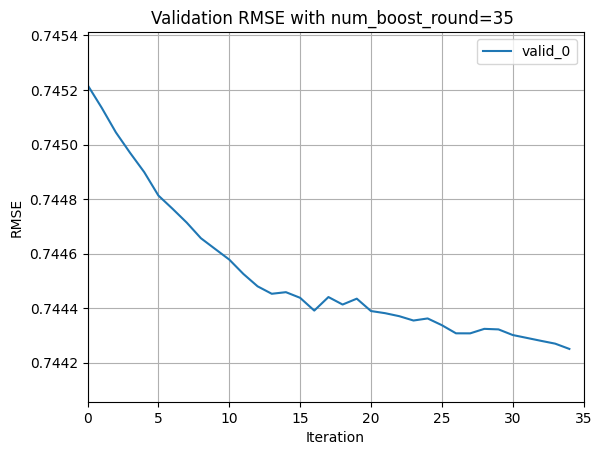

In [16]:
lgb.plot_metric(evals_result, metric='rmse')  
plt.title("Validation RMSE with num_boost_round=35 ")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.show()

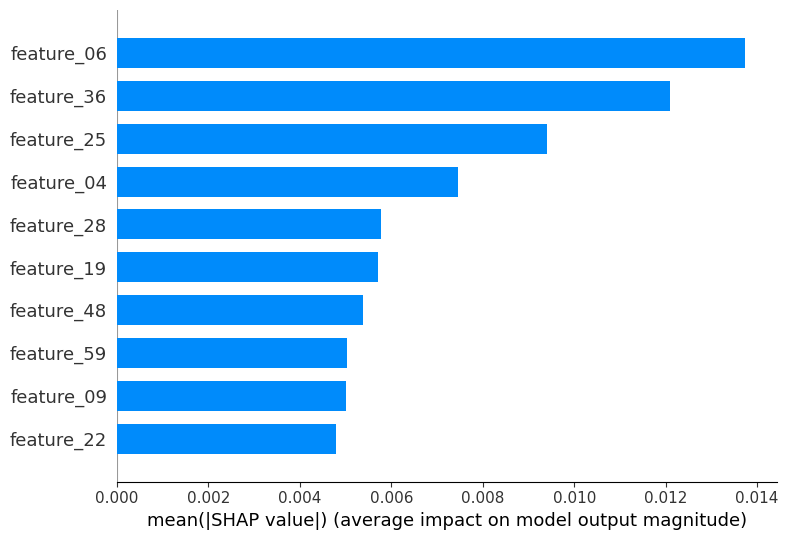

In [24]:
shap_values = model.predict(X_test, pred_contrib=True)
shap.summary_plot(shap_values[:, :-1],X_test,max_display=10,plot_type='bar')

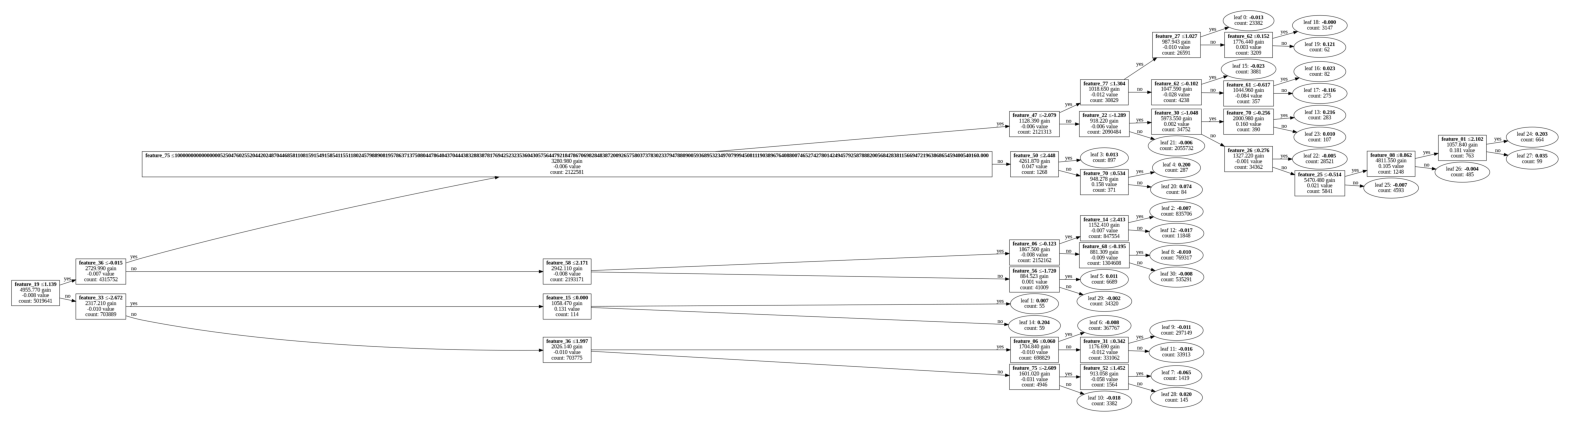

In [43]:
lgb.plot_tree(booster=model,
              tree_index=0,
              figsize=(20, 8),
              show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'])
plt.show()

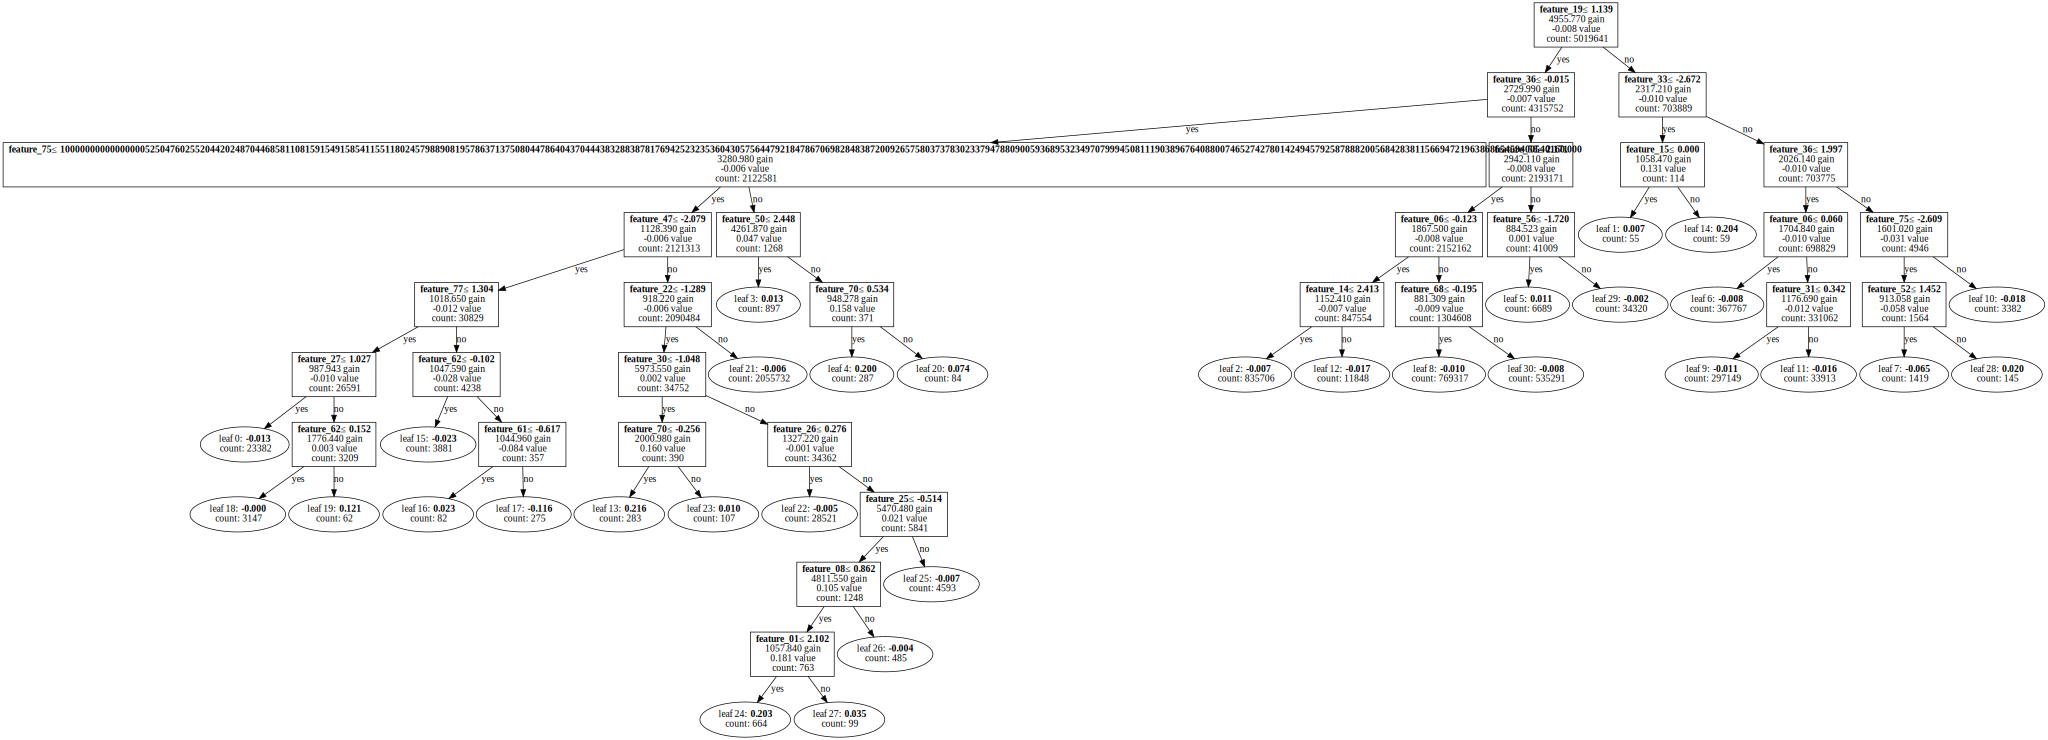

In [17]:
graph = lgb.create_tree_digraph(
    booster=model,    
    tree_index=0,         
    show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'],  
    orientation='LR'  
)
graph

## 2.3 - EDA Weight Column

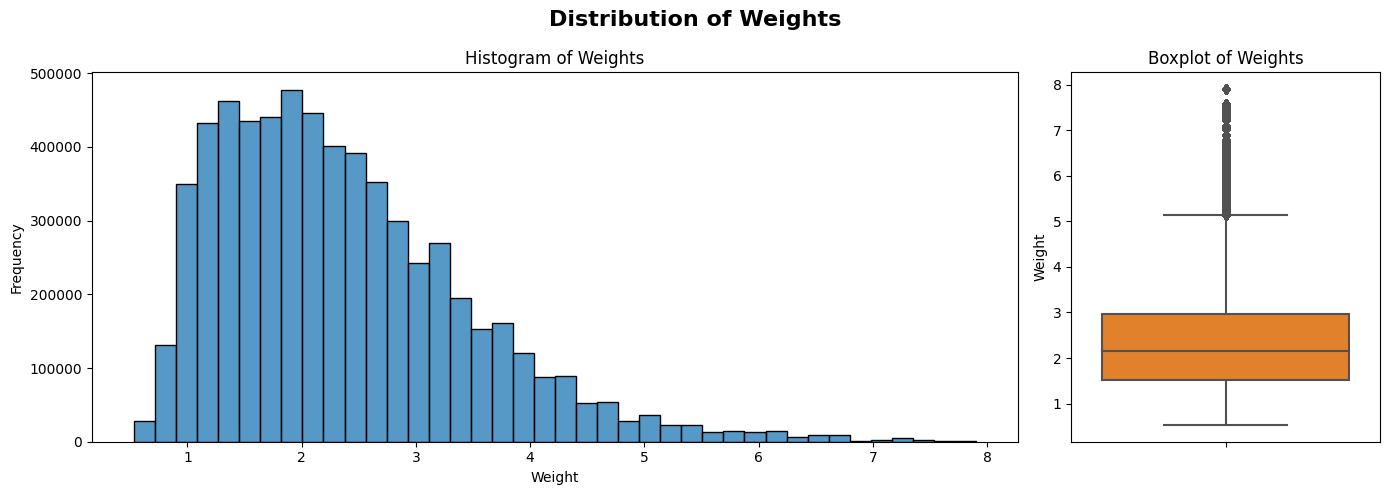

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), width_ratios=[3, 1])

sns.histplot(train_df, x="weight", bins=40, ax=axes[0], color="#1f77b4")
axes[0].set(title="Histogram of Weights", xlabel="Weight", ylabel="Frequency")

sns.boxplot(train_df, y="weight", ax=axes[1], color="#ff7f0e")
axes[1].set(title="Boxplot of Weights", ylabel="Weight")

fig.suptitle("Distribution of Weights", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()


## 2.4 - EDA Symbol_id Column

In [5]:
unique_symbols = train_df['symbol_id'].nunique()
print(f"Number of unique symbols: {unique_symbols}")

Number of unique symbols: 39


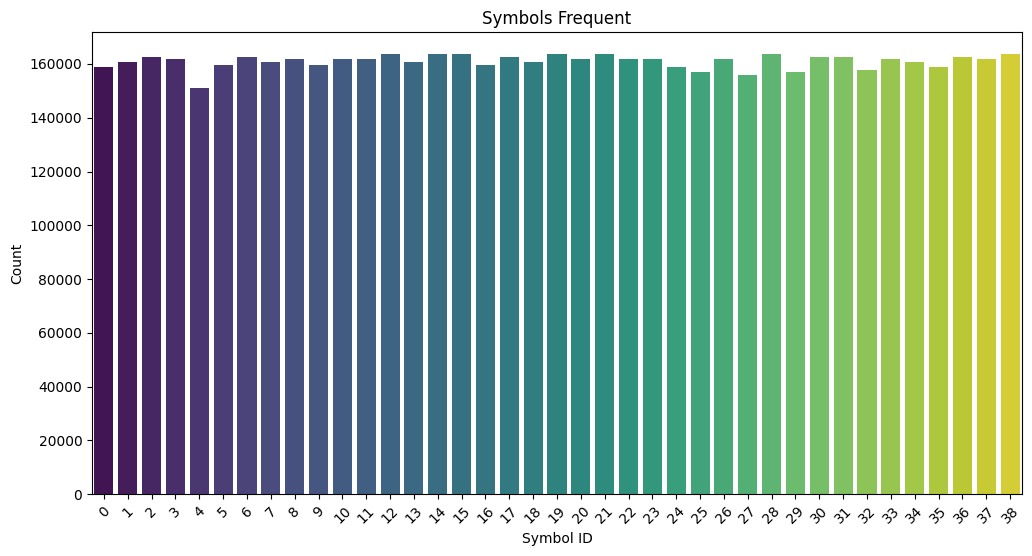

In [29]:
symbol_counts = train_df['symbol_id'].value_counts().reset_index()
plt.figure(figsize=(12,6))
sns.barplot(x='symbol_id', y='count', data=symbol_counts, palette='viridis')
plt.title("Symbols Frequent")
plt.xlabel("Symbol ID")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

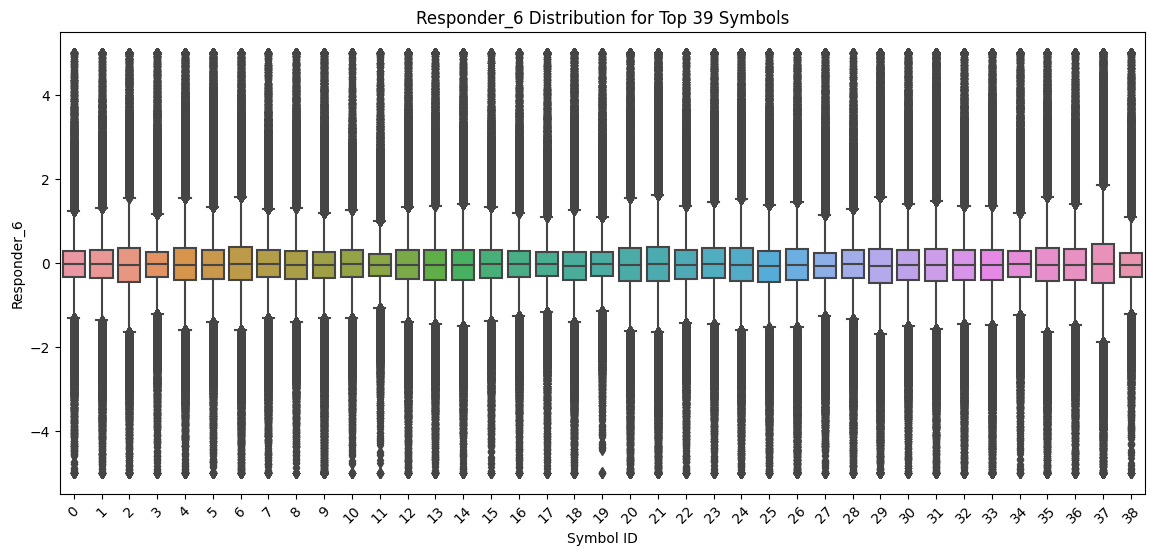

In [30]:
plt.figure(figsize=(14,6))
sns.boxplot(x='symbol_id', y='responder_6', data=train_df[train_df['symbol_id'].isin(symbol_counts.head(top_n)['symbol_id'])])
plt.title(f"Responder_6 Distribution for Symbols")
plt.xlabel("Symbol ID")
plt.ylabel("Responder_6")
plt.xticks(rotation=45)
plt.show()

**i will create features**

1. total_cumulative → overall total performance (positive = gain, negative = loss)

1. mean_of_daily_means → expected daily performance

1. std_of_daily_means → volatility between days (stability indicator)

1. mean_daily_std → intra-day volatility (within-day fluctuations)

1. max_drawdown → maximum potential loss (risk measure)

1. cumulative_slope → general trend direction (↑ rising / ↓ falling)


In [16]:
features_list = []
symbol_ids = train_df['symbol_id'].unique()

for symbol in symbol_ids:
    df_s = train_df[train_df['symbol_id'] == symbol].copy()
    # ترتيب زمني
    df_s = df_s.sort_values(['date_id', 'time_id']).reset_index(drop=True)
    
    # 1) نحسب المتوسط اليومي والانحراف اليومي لكل date_id
    daily = df_s.groupby('date_id')['responder_6'].agg(
        daily_mean = 'mean',
        daily_std  = 'std',
    ).dropna()
    
    if daily.shape[0] == 0:
        continue  # لو مفيش أيام كافية

    # 2) من البيانات الدقيقة نحسب cumulative عبر كل النقاط الزمنية (للحسابات التراكمية و drawdown)
    df_s['cumsum'] = df_s['responder_6'].cumsum()

    # 3) الآن نحستخلص الميزات على مستوي الرمز بناءً على التلخيص اليومي أو التراكمي
    total_cumulative = df_s['cumsum'].iloc[-1]                      # إجمالي التراكمي عبر الفترة
    mean_of_daily_means = daily['daily_mean'].mean()                # متوسط الـ daily means ← هذا هو "mean_daily" الحقيقية
    std_of_daily_means  = daily['daily_mean'].std()                 # تقلب المتوسطات اليومية
    mean_daily_std      = daily['daily_std'].mean()                 # متوسط الانحرافات اليومية
    max_drawdown = df_s['cumsum'].max() - df_s['cumsum'].min()      # أكبر انخفاض تراكمي
    cumulative_slope = (df_s['cumsum'].iloc[-1] - df_s['cumsum'].iloc[0]) / len(df_s)  # ميل تراكمي بوحدة لكل صف زمنى

    features_list.append({
        'symbol_id': symbol,
        'total_cumulative': total_cumulative,
        'mean_of_daily_means': mean_of_daily_means,
        'std_of_daily_means': std_of_daily_means,
        'mean_daily_std': mean_daily_std,
        'max_drawdown': max_drawdown,
        'cumulative_slope': cumulative_slope,
        'n_days': daily.shape[0],
        'n_rows': len(df_s)
    })

symbol_features = pd.DataFrame(features_list)
symbol_features = symbol_features.sort_values('mean_of_daily_means', ascending=False).reset_index(drop=True)
symbol_features


symbol_id  total_cumulative  mean_of_daily_means  std_of_daily_means  \
0          23       5037.768555             0.031163            0.144584   
1          37       4496.551758             0.027816            0.278293   
2           6       3045.809326             0.018729            0.151522   
3          21       3038.853027             0.018576            0.196472   
4           4       2774.332275             0.018372            0.196034   
5          34       2715.355469             0.016898            0.150008   
6          19       2470.205566             0.015100            0.161728   
7           3       2370.677490             0.014665            0.270910   
8          20       2233.874756             0.013819            0.314734   
9           5       1452.298218             0.009093            0.238730   
10         30       1361.768921             0.008374            0.299798   
11          2       1225.597290             0.007536            0.243936   
12         31        699.108215             0.004299            0.276501   
13          7        635.545349             0.003955            0.113427   
14         24        376.996185             0.002375            0.125839   
15         15        -71.215706            -0.000435            0.110340   
16         13       -226.480637            -0.001409            0.166570   
17         10       -280.801270            -0.001737            0.102678   
18          8       -562.365662            -0.003479            0.136638   
19         22       -578.736450            -0.003580            0.096150   
20         28       -928.604675            -0.005676            0.190942   
21         35      -1202.006226            -0.007572            0.152036   
22          1      -1299.121948            -0.008085            0.168740   
23         12      -1335.121460            -0.008162            0.134246   
24         38      -1463.424561            -0.008945            0.109049   
25         16      -1460.589111            -0.009145            0.138647   
26         17      -1534.320312            -0.009435            0.104667   
27          0      -1617.897583            -0.010191            0.147450   
28         36      -1909.707886            -0.011743            0.139072   
29         29      -2156.682373            -0.013753            0.237106   
30         26      -2933.408691            -0.018146            0.216392   
31         14      -3055.283447            -0.018676            0.109392   
32         11      -3172.715820            -0.019626            0.102686   
33         32      -3128.190186            -0.019826            0.112471   
34         27      -4579.437012            -0.029384            0.185120   
35         33      -4966.727051            -0.030724            0.195211   
36         18      -5343.145020            -0.033251            0.165274   
37          9      -6459.509766            -0.040443            0.212823   
38         25      -7388.835449            -0.047118            0.135818   

    mean_daily_std  max_drawdown  cumulative_slope  n_days  n_rows  
0         0.765462   5384.057617          0.031157     167  161656  
1         0.961824   5421.010025          0.027826     167  161656  
2         0.849493   3189.524933          0.018738     168  162624  
3         0.896044   4018.807678          0.018588     169  163592  
4         0.827101   3937.576447          0.018383     156  151008  
5         0.645091   3122.566666          0.016903     166  160688  
6         0.597138   3182.703568          0.015098     169  163592  
7         0.648449   4621.105957          0.014681     167  161656  
8         0.827347   3855.285156          0.013826     167  161656  
9         0.750974   4088.276001          0.009103     165  159720  
10        0.787457   4072.114868          0.008376     168  162624  
11        0.834307   3222.092712          0.007539     168  162624  
12        0.827091   3960.502808          0.004303     168  162624

In [17]:
train = train_df.merge(symbol_features, on='symbol_id', how='left')

In [18]:
train['risk_adjusted_return'] = train['mean_of_daily_means'] / train['std_of_daily_means']
train['drawdown_ratio'] = train['max_drawdown'] / train['total_cumulative']

1. risk_adjusted_return → performance adjusted by volatility
1. drawdown_ratio → loss severity relative to total gain

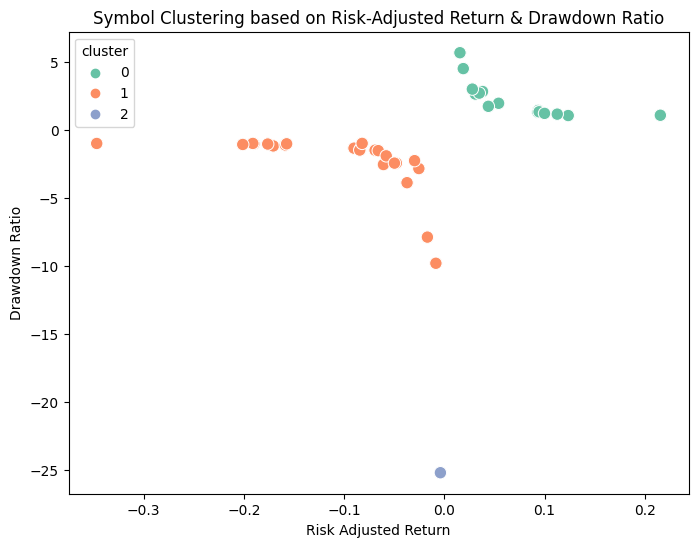

In [19]:
# اختار الأعمدة المهمة
features_for_cluster = ['risk_adjusted_return', 'drawdown_ratio', 'cumulative_slope']

# تجهيز البيانات
X = train[features_for_cluster].fillna(0)
X_scaled = StandardScaler().fit_transform(X)

# نختار عدد المجموعات
kmeans = KMeans(n_clusters=3, random_state=42)
train['cluster'] = kmeans.fit_predict(X_scaled)

# نرسم النتائج
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=train,
    x='risk_adjusted_return',
    y='drawdown_ratio',
    hue='cluster',
    palette='Set2',
    s=80
)
plt.title('Symbol Clustering based on Risk-Adjusted Return & Drawdown Ratio')
plt.xlabel('Risk Adjusted Return')
plt.ylabel('Drawdown Ratio')
plt.show()


In [20]:
train.groupby('cluster')[features_for_cluster].mean()

risk_adjusted_return  drawdown_ratio  cumulative_slope
cluster                                                        
0                    0.073172        2.231798          0.014056
1                   -0.104041       -2.303905         -0.015581
2                   -0.003945      -25.211731         -0.000445

In [21]:
# عرض الرموز (symbol_id) داخل كل cluster
for c in sorted(train['cluster'].unique()):
    symbols = train.loc[train['cluster'] == c, 'symbol_id'].unique()
    print(f"{len(symbols)} Symbols")
    print(symbols)
    print("-" * 60)

15 Symbols
[ 2  3  4  5  6  7 19 20 21 23 24 30 31 34 37]
------------------------------------------------------------
23 Symbols
[ 0  1  8  9 10 11 12 13 14 16 17 18 22 26 27 28 32 33 35 36 38 25 29]
------------------------------------------------------------
1 Symbols
[15]
------------------------------------------------------------


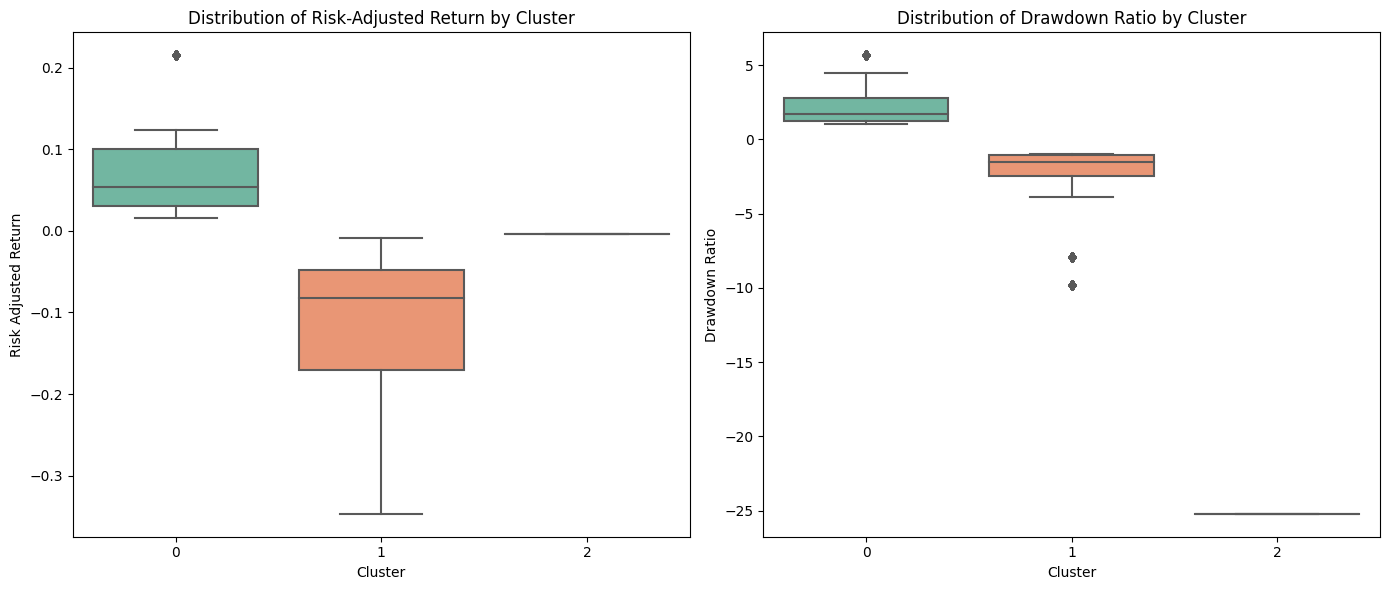

In [37]:
# نضبط حجم الشكل وعدد الأعمدة (رسمتين بجانب بعض)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1️⃣ توزيع Risk-Adjusted Return حسب الـ Cluster
sns.boxplot(data=train,x='cluster',y='risk_adjusted_return',palette='Set2',ax=axes[0])
axes[0].set_title("Distribution of Risk-Adjusted Return by Cluster")
axes[0].set_xlabel("Cluster")
axes[0].set_ylabel("Risk Adjusted Return")

# 2️⃣ توزيع Drawdown Ratio حسب الـ Cluster
sns.boxplot(data=train,x='cluster',y='drawdown_ratio',palette='Set2',ax=axes[1])
axes[1].set_title("Distribution of Drawdown Ratio by Cluster")
axes[1].set_xlabel("Cluster")
axes[1].set_ylabel("Drawdown Ratio")

# تحسين التنسيق
plt.tight_layout()
plt.show()


- The clustering process grouped symbols into **three main clusters**, representing different behavior patterns in the financial time series.
- **Cluster 0** and **Cluster 1** contain the majority of symbols (15 and 23 respectively), while **Cluster 2** includes only one symbol, which shows an outlier behavior.
- Symbols in **Cluster 2** tend to have **high volatility and irregular performance**, which might negatively affect the model’s stability and prediction accuracy.
- We can **reduce the weight** or **exclude** symbols from **Cluster 2** during training to minimize noise and improve model generalization.
- Alternatively, we can **train separate models** for the first two clusters (Cluster 0 and Cluster 1) since they represent stable and consistent behaviors.
- The cluster information will also be **added as a new categorical feature (`cluster`)** to help models like XGBoost or LightGBM distinguish between different symbol behavior patterns.

This clustering-based feature engineering approach enhances the model’s ability to capture market structure and handle heterogeneous symbol dynamics effectively.


In [22]:
train['cluster'] = train['cluster'].astype(int)

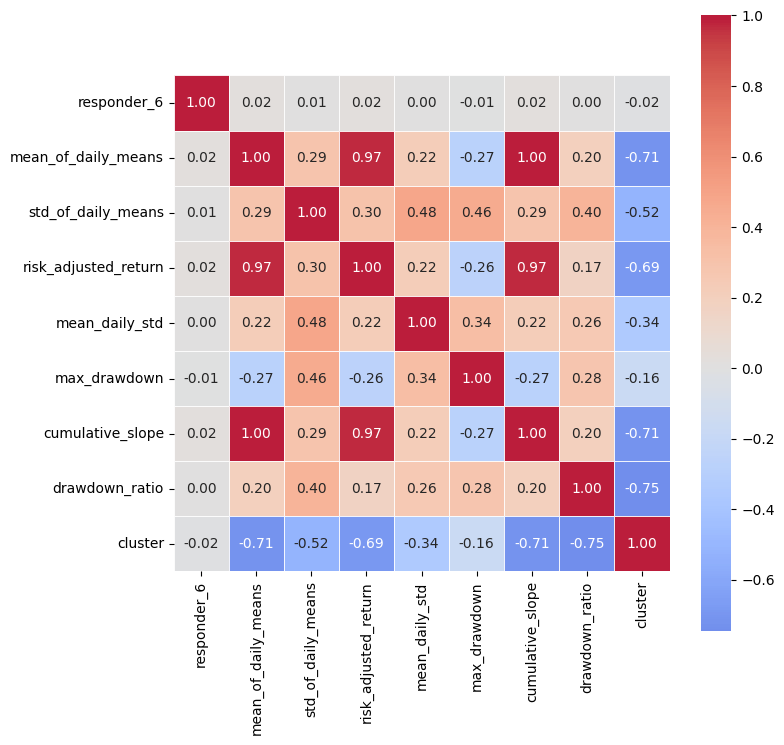

In [29]:
plt.figure(figsize=(8,8))
corr = train[['responder_6', 'mean_of_daily_means', 'std_of_daily_means','risk_adjusted_return',
                 'mean_daily_std', 'max_drawdown', 'cumulative_slope','drawdown_ratio','cluster']].corr()
sns.heatmap(corr, square=True, cmap="coolwarm", alpha =0.9, center= 0, linewidths=0.5, annot=True, fmt=".2f")
plt.show()

In [25]:
target_col = "responder_6"
weight_col = "weight"
responder_cols = train.filter(like="responder_").columns
#Time segmentation within each symbol id
train_list, test_list = [], []

for symbol, df_symbol in tqdm(train.groupby("symbol_id", group_keys=False), desc="Splitting by symbol_id"):
    df_symbol = df_symbol.sort_values(["date_id", "time_id"])  
    split_index = int(len(df_symbol) * 0.8)
    train_list.append(df_symbol.iloc[:split_index])
    test_list.append(df_symbol.iloc[split_index:])

train_data = pd.concat(train_list, ignore_index=True)
test_data = pd.concat(test_list, ignore_index=True)

print(f"✅ Train shape: {train_data.shape}")
print(f"✅ Test shape: {test_data.shape}")
print(f"🕓 Train date range: {train_data['date_id'].min()} → {train_data['date_id'].max()}")
print(f"🕓 Test date range: {test_data['date_id'].min()} → {test_data['date_id'].max()}")

# X,y,w
X_train = train_data.drop(["date_id", "time_id", "weight"] + list(responder_cols), axis=1)
y_train = train_data[target_col]
w_train = train_data[weight_col]

X_test = test_data.drop(["date_id", "time_id", "weight"] + list(responder_cols), axis=1)
y_test = test_data[target_col]
w_test = test_data[weight_col]

Splitting by symbol_id: 100%|██████████| 39/39 [00:06<00:00,  5.70it/s]


✅ Train shape: (5019641, 103)
✅ Test shape: (1254935, 103)
🕓 Train date range: 1530 → 1666
🕓 Test date range: 1656 → 1698


In [30]:
# Weighted Zero-Mean R²
def weighted_zero_mean_r2_np(y_true, y_pred, weights):
    y_true_zm = y_true - np.average(y_true, weights=weights)
    y_pred_zm = y_pred - np.average(y_pred, weights=weights)
    numerator = np.sum(weights * (y_true_zm - y_pred_zm) ** 2)
    denominator = np.sum(weights * (y_true_zm) ** 2)
    return 1 - numerator / denominator

def weighted_zero_mean_r2_lgb(y_pred, dataset):
    """Custom version for LightGBM (feval)"""
    y_true = dataset.get_label()
    weights = dataset.get_weight()
    y_true_zm = y_true - np.average(y_true, weights=weights)
    y_pred_zm = y_pred - np.average(y_pred, weights=weights)
    numerator = np.sum(weights * (y_true_zm - y_pred_zm) ** 2)
    denominator = np.sum(weights * (y_true_zm) ** 2)
    r2 = 1 - numerator / denominator
    return "weighted_zero_mean_r2", r2, True  

# Train LightGBM model (Regression)
train_dataset = lgb.Dataset(X_train, label=y_train, weight=w_train)
test_dataset = lgb.Dataset(X_test, label=y_test, weight=w_test)

params = {
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "max_depth": -1,
    "seed": 42
}

evals_result = {}

model = lgb.train(
    params,
    train_set=train_dataset,
    valid_sets=[test_dataset],
    num_boost_round=200,
    feval=weighted_zero_mean_r2_lgb,
    callbacks=[lgb.record_evaluation(evals_result)]
)


y_pred = model.predict(X_test)
rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))
r2_weighted = weighted_zero_mean_r2_np(y_test.values, y_pred, w_test.values)

print(f"RMSE: {rmse:.6f}")
print(f"Weighted Zero-Mean R²: {r2_weighted:.6f}")

RMSE: 0.764949
Weighted Zero-Mean R²: 0.002887


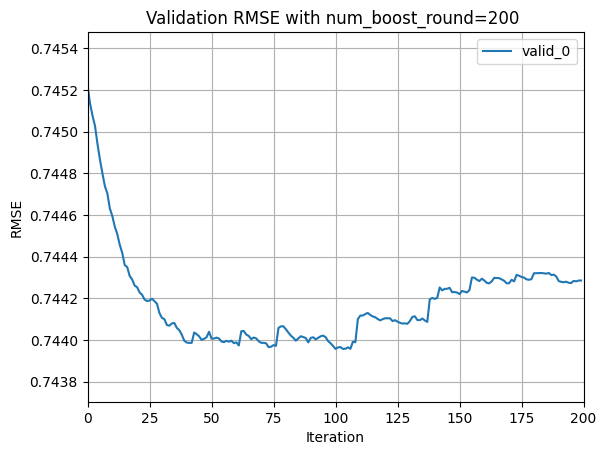

In [32]:
lgb.plot_metric(evals_result, metric='rmse')  
plt.title("Validation RMSE with num_boost_round=200 ")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.show()

In [33]:
evals_result = {}

model = lgb.train(
    params,
    train_set=train_dataset,
    valid_sets=[test_dataset],
    num_boost_round=100,
    feval=weighted_zero_mean_r2_lgb,
    callbacks=[lgb.record_evaluation(evals_result)]
)


y_pred = model.predict(X_test)
rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))
r2_weighted = weighted_zero_mean_r2_np(y_test.values, y_pred, w_test.values)

print(f"RMSE: {rmse:.6f}")
print(f"Weighted Zero-Mean R²: {r2_weighted:.6f}")

RMSE: 0.764711
Weighted Zero-Mean R²: 0.003685


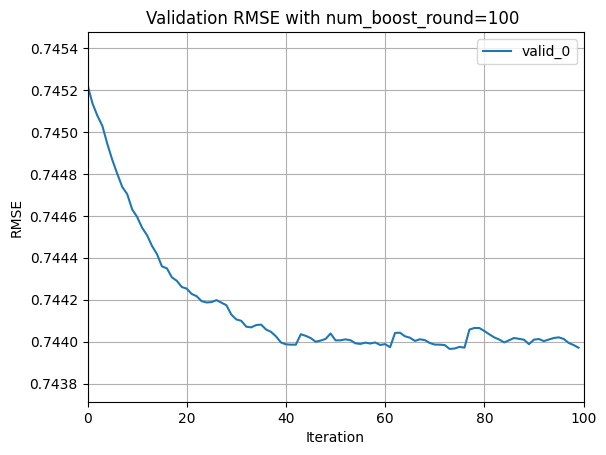

In [35]:
lgb.plot_metric(evals_result, metric='rmse')  
plt.title("Validation RMSE with num_boost_round=100 ")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.show()

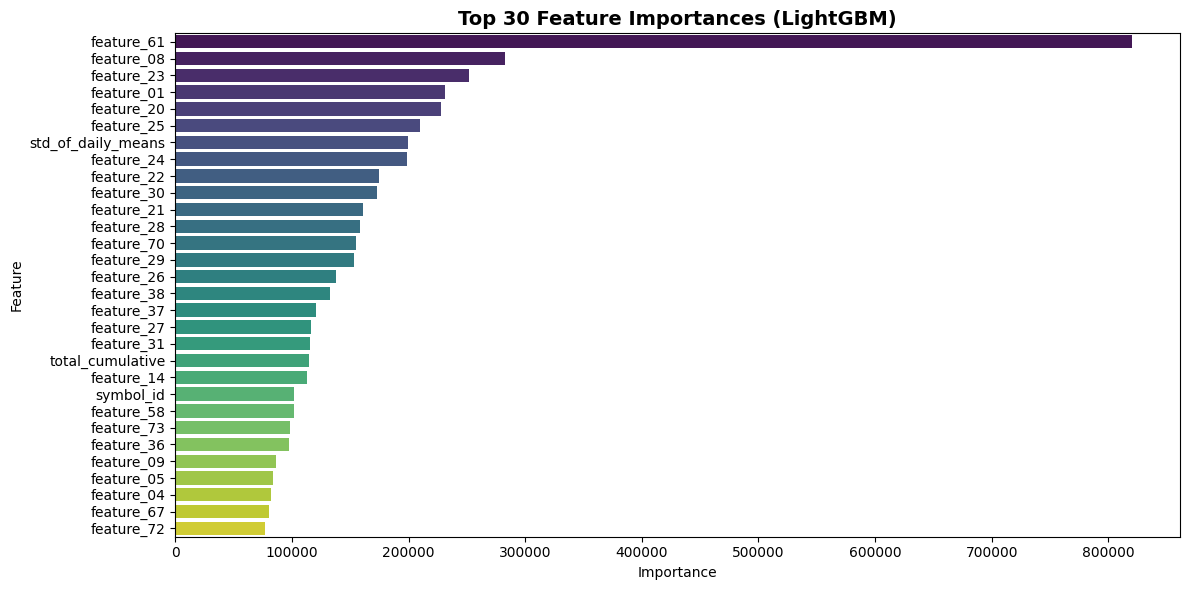


Features above 25th percentile (68 features):
 ['feature_61', 'feature_08', 'feature_23', 'feature_01', 'feature_20', 'feature_25', 'std_of_daily_means', 'feature_24', 'feature_22', 'feature_30', 'feature_21', 'feature_28', 'feature_70', 'feature_29', 'feature_26', 'feature_38', 'feature_37', 'feature_27', 'feature_31', 'total_cumulative', 'feature_14', 'symbol_id', 'feature_58', 'feature_73', 'feature_36', 'feature_09', 'feature_05', 'feature_04', 'feature_67', 'feature_72', 'feature_19', 'feature_74', 'feature_50', 'feature_75', 'feature_33', 'feature_06', 'feature_12', 'feature_15', 'feature_66', 'feature_53', 'feature_10', 'feature_69', 'feature_07', 'feature_65', 'feature_34', 'feature_62', 'feature_78', 'feature_76', 'feature_32', 'feature_00', 'feature_47', 'feature_77', 'max_drawdown', 'feature_11', 'feature_39', 'feature_18', 'feature_42', 'feature_02', 'feature_60', 'mean_daily_std', 'feature_68', 'feature_52', 'feature_35', 'feature_03', 'feature_16', 'feature_56', 'feature

In [32]:
# Feature Importance
importance = pd.DataFrame({
    "feature": model.feature_name(),
    "importance": model.feature_importance(importance_type="gain")
}).sort_values(by="importance", ascending=False).reset_index(drop=True)

# Plot Top 30 Feature Importances
plt.figure(figsize=(12, 6))
sns.barplot(x="importance", y="feature", data=importance.head(30), palette="viridis")
plt.title("Top 30 Feature Importances (LightGBM)", fontsize=14, fontweight="bold")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Calculate Percentile Thresholds
p25 = importance["importance"].quantile(0.25)
p50 = importance["importance"].quantile(0.50)
p75 = importance["importance"].quantile(0.75)

features_p25 = importance[importance["importance"] > p25]["feature"].tolist()
features_p50 = importance[importance["importance"] > p50]["feature"].tolist()
features_p75 = importance[importance["importance"] > p75]["feature"].tolist()

print(f"\nFeatures above 25th percentile ({len(features_p25)} features):\n {features_p25}")
print(f"\nFeatures above 50th percentile ({len(features_p50)} features):\n {features_p50}")
print(f"\nFeatures above 75th percentile ({len(features_p75)} features):\n {features_p75}")

In [ ]:
shap_values = model.predict(X_test, pred_contrib=True)
shap.summary_plot(shap_values[:, :-1],X_test,max_display=10,plot_type='bar')

**EDA Summary — Symbol-Level Insights**

**The analysis was conducted at the symbol level to understand the behavior of responder_6 over time.**

**Advanced statistical features were engineered, including:**

1. total_cumulative – overall long-term performance trend.

1. mean_of_daily_means – expected average daily return.
   
1. std_of_daily_means – volatility between days.

1. mean_daily_std – intra-day volatility.

1. max_drawdown – maximum cumulative loss (risk indicator).

1. cumulative_slope – overall directional trend over time.

1. risk_adjusted_return – return adjusted by volatility (similar to Sharpe Ratio).

1. drawdown_ratio – ratio of total loss to total cumulative performance.

**K-Means clustering was applied to categorize symbols into three performance groups:**

1. Cluster 0 — High-performing symbols: high returns and low risk.

1. Cluster 1 — Underperforming symbols: negative returns and high risk.

1. Cluster 2 — Neutral/unstable symbols: moderate returns with higher volatility.

* These insights help identify strong vs. weak symbols and can enhance model performance by incorporating cluster labels as additional predictive features in the machine learning pipeline.

## 2.5 - EDA date_id Column

In [64]:
print(train_df['date_id'].min())
print(train_df['date_id'].max())
print(train_df['date_id'].nunique())

1530
1698
169


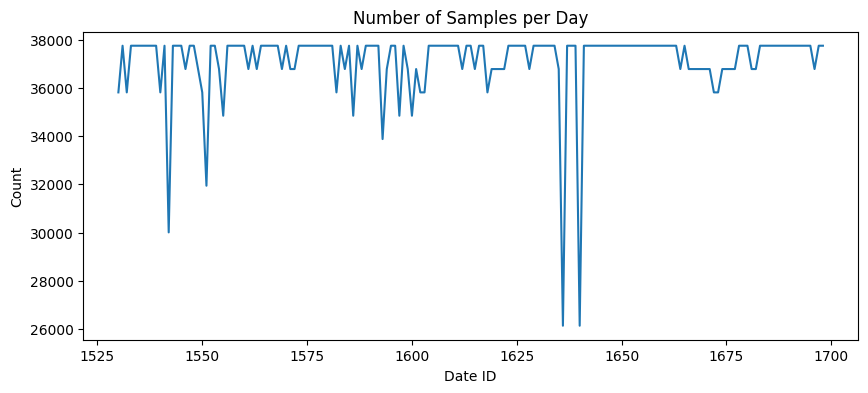

In [23]:
train_df.groupby('date_id').size().plot(figsize=(10,4))
plt.title("Number of Samples per Day")
plt.xlabel("Date ID")
plt.ylabel("Count")
plt.show()

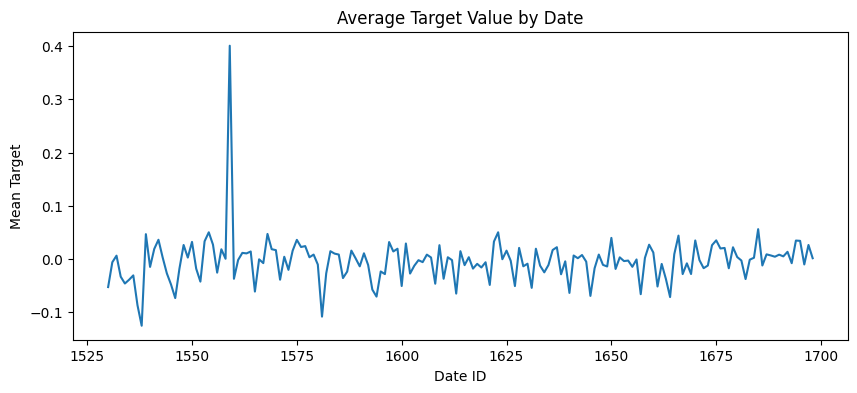

In [26]:
train_df.groupby('date_id')['responder_6'].mean().plot(figsize=(10,4))
plt.title("Average Target Value by Date")
plt.xlabel("Date ID")
plt.ylabel("Mean Target")
plt.show()

### Daily Performance Stability

- Most `date_id` values show a stable mean target between **−0.1 and +0.1**, indicating consistent daily performance.
- One specific day exhibits a **spike around +0.4**, likely representing an exceptional market event or data anomaly.
- Such an outlier may disproportionately affect model training; it should be analyzed further.
- Next step: perform **outlier detection** on daily means using z-scores to confirm and handle rare events appropriately.

In [72]:
daily_means = train_df.groupby('date_id')['responder_6'].mean()
z_scores = (daily_means - daily_means.mean()) / daily_means.std()
outliers = daily_means[z_scores.abs() > 3]  
print(outliers)

date_id
1559    0.400839
Name: responder_6, dtype: float32


In [80]:
train_df[train_df['date_id']==1559]['responder_6'].describe()

count    37752.000000
mean         0.400839
std          2.348258
min         -5.000000
25%         -0.978278
50%         -0.018211
75%          1.565556
max          5.000000
Name: responder_6, dtype: float64

📅 date_id = 1559
Number of symbols: 39
Mean responder_6: 0.4008
Std responder_6: 2.3483


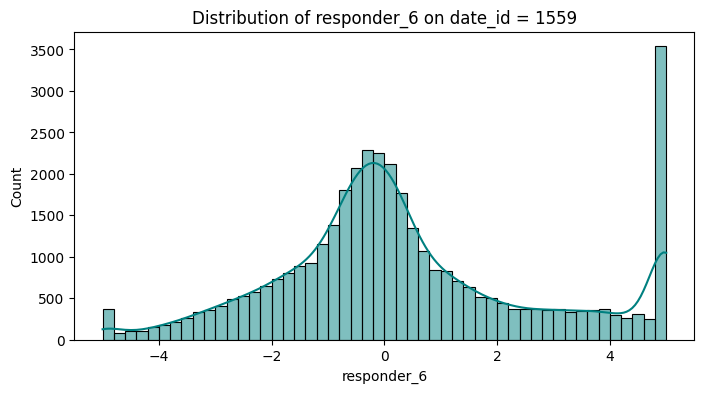

In [82]:
day = 1559
subset = train[train['date_id'] == day]

print(f"date_id = {day}")
print(f"Number of symbols: {subset['symbol_id'].nunique()}")
print(f"Mean responder_6: {subset['responder_6'].mean():.4f}")
print(f"Std responder_6: {subset['responder_6'].std():.4f}")

# عرض التوزيع
plt.figure(figsize=(8,4))
sns.histplot(subset['responder_6'], bins=50, kde=True, color='teal')
plt.title(f"Distribution of responder_6 on date_id = {day}")
plt.show()

In [91]:
day_1559 = train_df[train_df['date_id'] == 1559]
day_1559.groupby('symbol_id')['responder_6'].mean().sort_values(ascending=False).head(10)

symbol_id
20    3.722509
30    3.582253
3     3.293093
37    3.250857
31    3.232068
2     2.854467
5     2.660344
29    2.480863
21    2.036460
4     1.948425
Name: responder_6, dtype: float32

###  Analysis of Date_ID = 1559

- A strong positive spike in the mean target value was observed on **date_id = 1559** (≈ 0.40), which is an extreme outlier compared to other dates (normally between -0.1 and 0.1).  
- Upon deeper inspection by symbol:
  - A few symbols such as **symbol_id = 20, 30, 3, 37, and 31** recorded exceptionally high target values (above 3.0),  
  - While most other symbols had values near zero or even negative.
- This indicates that the abnormal rise on that date was **not market-wide**, but rather **driven by a small subset of symbols**.
- These symbols likely represent **anomalous behavior**, possibly due to:
  - Data irregularities,  
  - Sudden market shocks or isolated trading events,  
  - Or extreme volatility within those assets.
- ✅ **Decision:** We will **drop this date (date_id = 1559)** from the training data to prevent distortion in model learning.


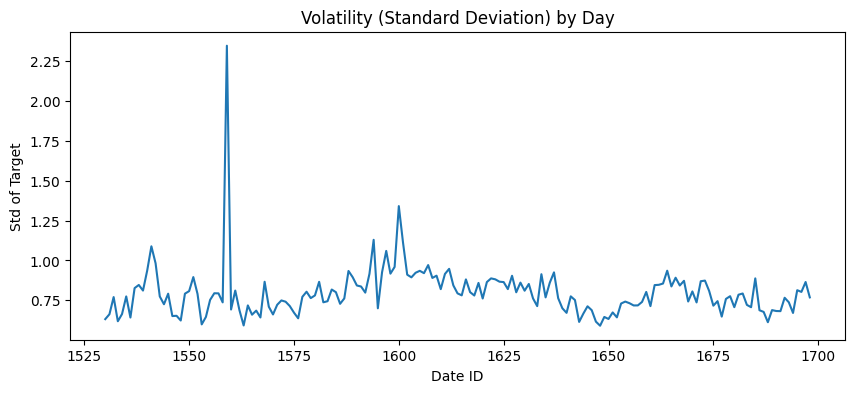

In [27]:
train_df.groupby('date_id')['responder_6'].std().plot(figsize=(10,4))
plt.title("Volatility (Standard Deviation) by Day")
plt.xlabel("Date ID")
plt.ylabel("Std of Target")
plt.show()

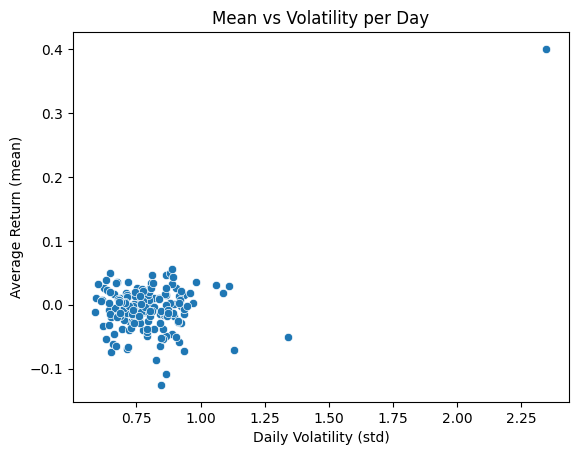

In [28]:
daily_stats = train_df.groupby('date_id')['responder_6'].agg(['mean','std'])
sns.scatterplot(data=daily_stats, x='std', y='mean')
plt.title("Mean vs Volatility per Day")
plt.xlabel("Daily Volatility (std)")
plt.ylabel("Average Return (mean)")
plt.show()

## 2.6 - EDA time_id Column

In [65]:
print(train_df['time_id'].min())
print(train_df['time_id'].max())
print(train_df['time_id'].nunique())

0
967
968


In [66]:
train_df.groupby('date_id')['time_id'].nunique().head()

date_id
1530    968
1531    968
1532    968
1533    968
1534    968
Name: time_id, dtype: int64

In [67]:
print(train_df.groupby('date_id')['time_id'].nunique().min())
print(train_df.groupby('date_id')['time_id'].nunique().max())

968
968


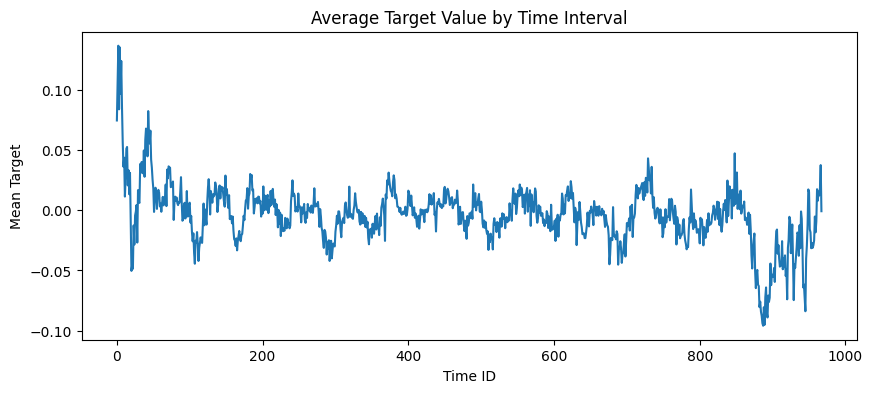

In [34]:
train_df.groupby('time_id')['responder_6'].mean().plot(figsize=(10,4))
plt.title("Average Target Value by Time Interval")
plt.xlabel("Time ID")
plt.ylabel("Mean Target")
plt.show()

In [102]:
train_df.groupby('time_id')['responder_6'].agg(['mean', 'std', 'count']).head(10)

mean       std  count
time_id                           
0        0.074666  1.734444   6482
1        0.105092  1.687731   6482
2        0.136785  1.665165   6482
3        0.083934  1.627302   6482
4        0.135404  1.602335   6482
5        0.097024  1.579693   6482
6        0.124107  1.552006   6482
7        0.086221  1.542890   6482
8        0.057029  1.530205   6482
9        0.036247  1.509444   6482

In [103]:
train_df.groupby('time_id')['responder_6'].agg(['mean', 'std', 'count']).tail(10)

mean       std  count
time_id                           
958     -0.005160  0.875397   6482
959     -0.018252  0.834927   6482
960     -0.009219  0.812678   6482
961      0.017546  0.750734   6482
962      0.007975  0.717958   6482
963      0.015589  0.669269   6482
964      0.012331  0.610685   6482
965      0.018502  0.563540   6482
966      0.037582  0.489210   6482
967     -0.000732  0.386638   6482

Opening Period Analysis
In the early time intervals of the day, the values show the following patterns:

Mean: Positive (≈ 0.1–0.13)

Standard Deviation (std): Very high (≈ 1.7)

📈 This indicates that the market is highly active during the opening period,
with strong movements and clear directional trends — a sign of intense volatility and trading volume at the start of the session.

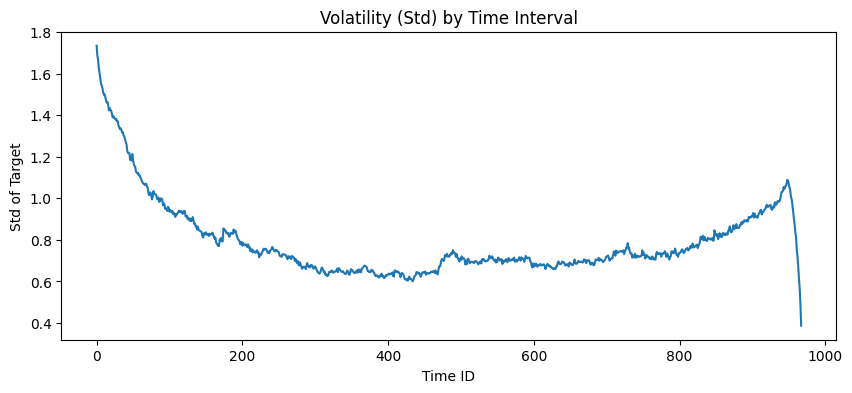

In [37]:
train_df.groupby('time_id')['responder_6'].std().plot(figsize=(10,4))
plt.title("Volatility (Std) by Time Interval")
plt.xlabel("Time ID")
plt.ylabel("Std of Target")
plt.show()

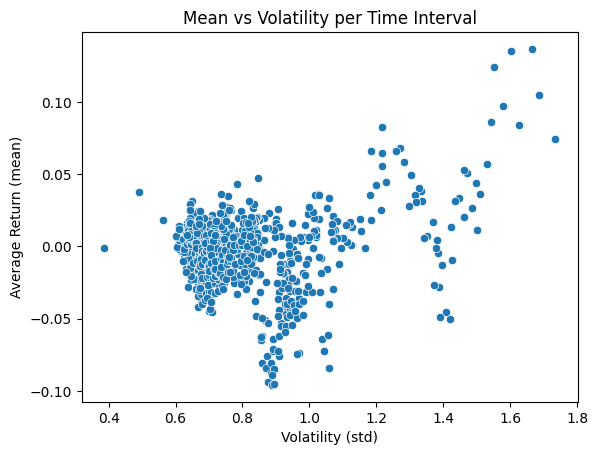

In [39]:
time_stats = train_df.groupby('time_id')['responder_6'].agg(['mean', 'std'])
sns.scatterplot(data=time_stats, x='std', y='mean')
plt.title("Mean vs Volatility per Time Interval")
plt.xlabel("Volatility (std)")
plt.ylabel("Average Return (mean)")
plt.show()

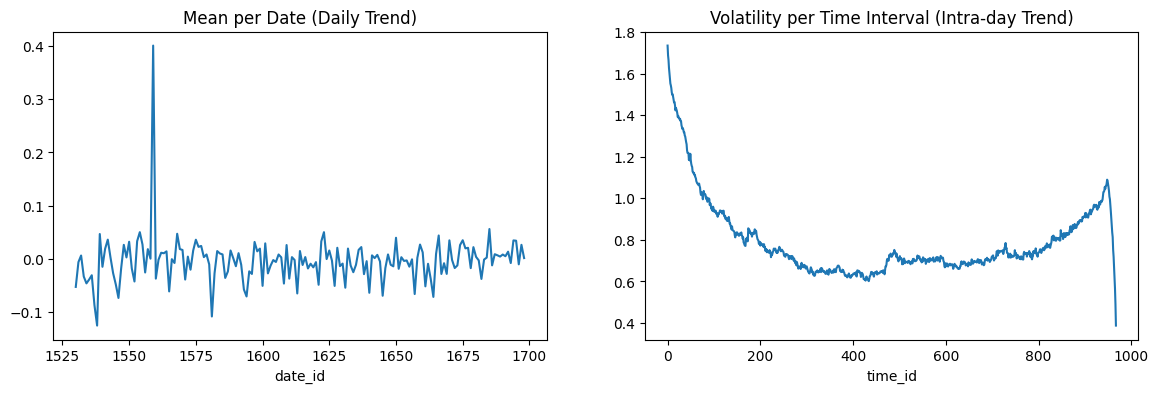

In [47]:
daily_mean = train.groupby('date_id')['responder_6'].mean()
intra_day_std = train.groupby('time_id')['responder_6'].std()

fig, axes = plt.subplots(1, 2, figsize=(14,4))
daily_mean.plot(ax=axes[0], title="Mean per Date (Daily Trend)")
intra_day_std.plot(ax=axes[1], title="Volatility per Time Interval (Intra-day Trend)")
plt.show()

**Time_ID Analysis Summary**

Analysis of responder_6 across time_id revealed:

High volatility during the opening periods (mean ≈ 0.1–0.13, std ≈ 1.7).

Gradual stabilization toward the end of the day.

These fluctuations are not anomalies, but reflect real intraday market dynamics — they are signals, not noise.

✅ **Decision:** Add time-based features (e.g., is_opening, time_id_norm, volatility_period)
→ to help the model learn that market behavior changes over time within the same day.

In [5]:
target_col = "responder_6"
weight_col = "weight"
responder_cols = train_df.filter(like="responder_").columns
#Time segmentation within each symbol id
train_list, test_list = [], []

for symbol, df_symbol in tqdm(train_df.groupby("symbol_id", group_keys=False), desc="Splitting by symbol_id"):
    df_symbol = df_symbol.sort_values(["date_id", "time_id"])  
    split_index = int(len(df_symbol) * 0.8)
    train_list.append(df_symbol.iloc[:split_index])
    test_list.append(df_symbol.iloc[split_index:])

train_data = pd.concat(train_list, ignore_index=True)
test_data = pd.concat(test_list, ignore_index=True)

print(f"✅ Train shape: {train_data.shape}")
print(f"✅ Test shape: {test_data.shape}")
print(f"🕓 Train date range: {train_data['date_id'].min()} → {train_data['date_id'].max()}")
print(f"🕓 Test date range: {test_data['date_id'].min()} → {test_data['date_id'].max()}")

# X,y,w
X_train = train_data.drop(["date_id", "time_id", "weight","responder_6"],axis=1)
y_train = train_data[target_col]
w_train = train_data[weight_col]

X_test = test_data.drop(["date_id", "time_id", "weight","responder_6"], axis=1)
y_test = test_data[target_col]
w_test = test_data[weight_col]

Splitting by symbol_id: 100%|██████████| 39/39 [00:04<00:00,  8.60it/s]


✅ Train shape: (5019641, 92)
✅ Test shape: (1254935, 92)
🕓 Train date range: 1530 → 1666
🕓 Test date range: 1656 → 1698


In [6]:
# Weighted Zero-Mean R²
def weighted_zero_mean_r2_np(y_true, y_pred, weights):
    y_true_zm = y_true - np.average(y_true, weights=weights)
    y_pred_zm = y_pred - np.average(y_pred, weights=weights)
    numerator = np.sum(weights * (y_true_zm - y_pred_zm) ** 2)
    denominator = np.sum(weights * (y_true_zm) ** 2)
    return 1 - numerator / denominator

def weighted_zero_mean_r2_lgb(y_pred, dataset):
    """Custom version for LightGBM (feval)"""
    y_true = dataset.get_label()
    weights = dataset.get_weight()
    y_true_zm = y_true - np.average(y_true, weights=weights)
    y_pred_zm = y_pred - np.average(y_pred, weights=weights)
    numerator = np.sum(weights * (y_true_zm - y_pred_zm) ** 2)
    denominator = np.sum(weights * (y_true_zm) ** 2)
    r2 = 1 - numerator / denominator
    return "weighted_zero_mean_r2", r2, True  

# Train LightGBM model (Regression)
train_dataset = lgb.Dataset(X_train, label=y_train, weight=w_train)
test_dataset = lgb.Dataset(X_test, label=y_test, weight=w_test)

params = {
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "max_depth": -1,
    "seed": 42
}

evals_result = {}

model = lgb.train(
    params,
    train_set=train_dataset,
    valid_sets=[test_dataset],
    num_boost_round=100,
    feval=weighted_zero_mean_r2_lgb,
    callbacks=[lgb.record_evaluation(evals_result)]
)


y_pred = model.predict(X_test)
rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))
r2_weighted = weighted_zero_mean_r2_np(y_test.values, y_pred, w_test.values)

print(f"RMSE: {rmse:.6f}")
print(f"Weighted Zero-Mean R²: {r2_weighted:.6f}")

RMSE: 0.271541
Weighted Zero-Mean R²: 0.873056


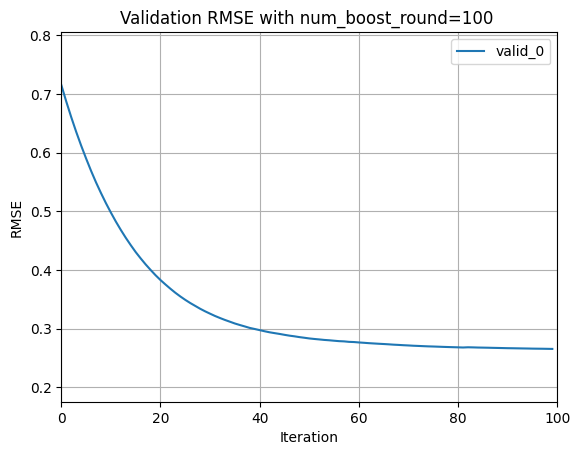

In [7]:
lgb.plot_metric(evals_result, metric='rmse')  
plt.title("Validation RMSE with num_boost_round=100 ")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.show()

In [23]:
target_col = "responder_6"
weight_col = "weight"
responder_cols = train.filter(like="responder_").columns
#Time segmentation within each symbol id
train_list, test_list = [], []

for symbol, df_symbol in tqdm(train.groupby("symbol_id", group_keys=False), desc="Splitting by symbol_id"):
    df_symbol = df_symbol.sort_values(["date_id", "time_id"])  
    split_index = int(len(df_symbol) * 0.8)
    train_list.append(df_symbol.iloc[:split_index])
    test_list.append(df_symbol.iloc[split_index:])

train_data = pd.concat(train_list, ignore_index=True)
test_data = pd.concat(test_list, ignore_index=True)

print(f"✅ Train shape: {train_data.shape}")
print(f"✅ Test shape: {test_data.shape}")
print(f"🕓 Train date range: {train_data['date_id'].min()} → {train_data['date_id'].max()}")
print(f"🕓 Test date range: {test_data['date_id'].min()} → {test_data['date_id'].max()}")

# X,y,w
X_train = train_data.drop(["date_id", "time_id", "weight","responder_6"],axis=1)
y_train = train_data[target_col]
w_train = train_data[weight_col]

X_test = test_data.drop(["date_id", "time_id", "weight","responder_6"], axis=1)
y_test = test_data[target_col]
w_test = test_data[weight_col]

Splitting by symbol_id: 100%|██████████| 39/39 [00:07<00:00,  5.28it/s]


✅ Train shape: (5019641, 103)
✅ Test shape: (1254935, 103)
🕓 Train date range: 1530 → 1666
🕓 Test date range: 1656 → 1698


In [24]:
evals_result = {}

model = lgb.train(
    params,
    train_set=train_dataset,
    valid_sets=[test_dataset],
    num_boost_round=100,
    feval=weighted_zero_mean_r2_lgb,
    callbacks=[lgb.record_evaluation(evals_result)]
)


y_pred = model.predict(X_test)
rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))
r2_weighted = weighted_zero_mean_r2_np(y_test.values, y_pred, w_test.values)

print(f"RMSE: {rmse:.6f}")
print(f"Weighted Zero-Mean R²: {r2_weighted:.6f}")

RMSE: 0.271922
Weighted Zero-Mean R²: 0.872694


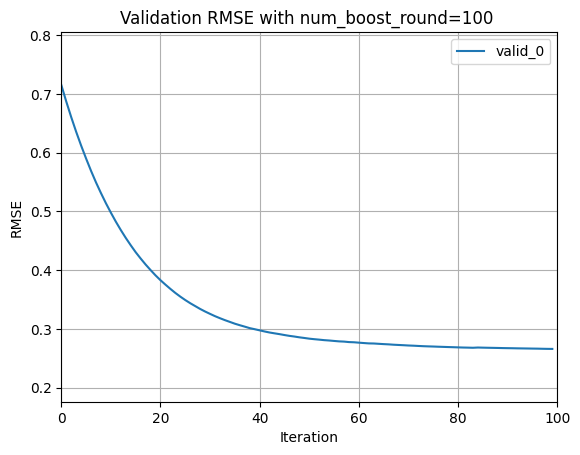

In [25]:
lgb.plot_metric(evals_result, metric='rmse')  
plt.title("Validation RMSE with num_boost_round=100 ")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.show()